In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16, vgg19
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Image Transformation Network
This is based on Justin C. Johnson's paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Here, we are going to make the proposed network for generating the end image (as in the convolutional neural network the will learn weights in order to efficiently calculate how to create an image based on a style)

### Architecture
![Architecture](./images/transformation-network-table.PNG)

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # For the transformation network, the authors only used 3x3 convolutions
        self.conv = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 3)
        self.batch_norm = nn.InstanceNorm2d(self.out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        orig_x = x.clone()
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        # Second convolution
        x = self.conv(x)
        x = self.batch_norm(x)
        
        # Now add the original to the new one (and use center cropping)
        # Calulate the different between the size of each feature (in terms 
        # of height/width) to get the center of the original feature
        height_diff = orig_x.size()[2] - x.size()[2]
        width_diff = orig_x.size()[3] - x.size()[3]
        
        # Add the original to the new (complete the residual block)
        x = x + orig_x[:, :,
                                 height_diff//2:(orig_x.size()[2] - height_diff//2), 
                                 width_diff//2:(orig_x.size()[3] - width_diff//2)]
        
        return x

In [3]:
class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        # Use reflection padding to keep the end shape
        self.ref_pad = nn.ReflectionPad2d(40)
        
        # Initial convolutions
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 9,
                               padding = 6,
                               padding_mode = 'reflect')
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               stride = 2)
        
        # Residual Blocks
        self.resblock1 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock2 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock3 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock4 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        self.resblock5 = ResidualBlock(in_channels = 128,
                                       out_channels = 128)
        
        # Transpose convoltutions
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128,
                                             out_channels=64,
                                             kernel_size=2,
                                             stride=2)
        
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,
                                              out_channels=32,
                                              kernel_size=2,
                                              stride=2)
        
        # End with one last convolution
        self.conv4 = nn.Conv2d(in_channels = 32,
                               out_channels = 3,
                               kernel_size = 9,
                               padding = 4,
                               padding_mode = 'reflect')
        
    def forward(self, x):
        # Apply reflection padding
        x = self.ref_pad(x)
        
        # Apply the initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply the residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)        
        
        #  Apply the transpose convolutions
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        
        # Apply the final convolution
        x = self.conv4(x)
        
        return x

In [5]:
# Test to confirm the residual network works
resblock = ResidualBlock(128, 128)
test = torch.randn(2, 128, 84, 84)
out = resblock(test)
print(out.size())

torch.Size([2, 128, 80, 80])


In [6]:
# Test to confirm the transormational network works
transformation_net = ImageTransformationNetwork()
test = torch.randn(2, 3, 256, 256)
out = transformation_net(test)
print(out.size())

torch.Size([2, 3, 256, 256])


### Cost Functions
Now we must implement the different cost functions

Style Relu Indices: 3, 8, 15, 22  
Content Relu Index: 15

In [4]:
class ForwardVGG19(torch.nn.Module):
    def __init__(self):
        super(ForwardVGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x, style):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if style:
                if i in {3, 8, 15, 22}:
                    results.append(x)
            
            else:
                if i == 15:
                    results.append(x)
        
        return results

forward_vgg = ForwardVGG19()

In [5]:
def normalize_batch(batch):
    """
    Before we send an image into the VGG16, we have to normalize it
    """
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] - vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] - vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] - vgg_means[2]
    return ret

In [6]:
def denormalize_batch(batch):
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] + vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] + vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] + vgg_means[2]
    return ret

In [7]:
def add_noise(batch):
    """
    For the input image, we have to add noise so that the loss between the content image and 
    input image is not 0
    """
    mean = 0.0
    std = 10.0
    ret = batch + np.random.normal(mean, std, batch.shape)
    ret = np.clip(batch, 0, 255)
    return ret

In [8]:
def compute_gram(matrix):
    """
    Computes the gram matrix
    """
    batches, channels, height, width = matrix.size()
    return (torch.matmul(matrix.view(batches, channels, -1),
            torch.transpose(matrix.view(batches, channels, -1), 1, 2)))


In [9]:
def compute_fro_norm(matrix):
    """
    Computes the frobenius norm
    """
    batches, height, width = matrix.size()
    return torch.norm(matrix.view(batches, 1, -1), 'fro', dim=2)

In [10]:
def content_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, False)
    target_layers = forward_vgg(target_norm, False)

    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + (1/(channels * height * width)) * \
                            (torch.sum(torch.square(input_layers[layer] - target_layers[layer])))
    
    return accumulated_loss

In [11]:
def style_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, True)
    target_layers = forward_vgg(target_norm, True)
    
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + 0.25 * ((1/(4 * channels**2 * (height * width) ** 2)) * \
                            torch.sum(torch.square(compute_gram(input_layers[layer]) -
                                                    compute_gram(target_layers[layer]))))
    
    return accumulated_loss

In [12]:
def total_variation_cost(input):
    tvloss = (
        torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
        torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
    )
    return tvloss

In [13]:
def total_cost(input, targets):
    REG_TV = 1e-4
    REG_STYLE = 1e-4
    REG_CONTENT = 1e-6
    content, style = targets
    closs = content_cost(input, content)
    sloss = style_cost(input, style)
    tvloss = total_variation_cost(input)
    
    return REG_CONTENT * closs + REG_STYLE * sloss + REG_TV * tvloss
    

### Data Loading

In [24]:
# Constants
IMG_DIMENSIONS = (256, 256)
DATA = list(glob.iglob('data/content_images/*'))
STYLE_IMAGE = np.asarray(Image.open('data/style_image.png').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]

# Make the style image a batch and convert
STYLE_IMAGE = STYLE_IMAGE.reshape(1, 3, 256, 256)
MAX_TRAIN = 80000
MAX_VAL = 81000
TOTAL_DATA = len(DATA)

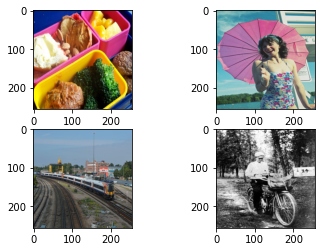

In [32]:
def show_sample_images():
    f, axarr = plt.subplots(2,2)
    
    # Show colored images
    axarr[0,0].imshow(np.asarray(Image.open(DATA[0]).resize(IMG_DIMENSIONS)))
    axarr[0,1].imshow(np.asarray(Image.open(DATA[4]).resize(IMG_DIMENSIONS)))
    axarr[1,0].imshow(np.asarray(Image.open(DATA[8]).resize(IMG_DIMENSIONS)))
    
    # Grayscale example
    grayscale = np.asarray(Image.open(DATA[13]).resize(IMG_DIMENSIONS))
    grayscale = np.stack((grayscale, grayscale, grayscale)).transpose(1, 2, 0)
    axarr[1,1].imshow(grayscale)
    
show_sample_images()

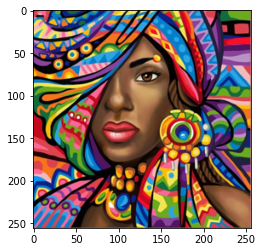

In [36]:
# Show the chosen style image
plt.imshow(STYLE_IMAGE[0].transpose(1, 2, 0))

In [15]:
def load_training_batch(current_batch, batch_size, set_type):
    """
    Load different batches of data (essentially a custom data loader for training, validation, and testing)
    """
    # The initial position is where we want to start getting the batch
    # So it is the starting index of the batch
    initial_pos = current_batch * batch_size
    
    # List to store the images
    images = []
    
    # Make sure the batch is within the [0, MAX_TRAIN]
    if set_type == 'train':
        if initial_pos + batch_size > MAX_TRAIN:
            batch_size = MAX_TRAIN - initial_pos
    
    # Make sure the batch is within the [MAX_TRAIN, MAX_VAL]
    elif set_type == 'val':
        initial_pos = MAX_TRAIN + initial_pos
        if initial_pos + batch_size > MAX_VAL:
            batch_size = MAX_VAL - initial_pos
    
    # Make sure the batch is within the [MAX_VAL, TOTAL_DATA]
    elif set_type == 'test':
        initial_pos = MAX_VAL + initial_pos
        if initial_pos + batch_size > TOTAL_DATA:
            batch_size = TOTAL_DATA - initial_pos

    for f in DATA[initial_pos:initial_pos + batch_size]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))
        
        # If the image is grayscale, stack the image 3 times to get 3 channels
        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue
            
        # Transpose the image to have channels first
        image = image.transpose(2, 0, 1)
        images.append(image)
    
    return np.array(images)

### Training

In [18]:
BATCH_SIZE = 4
STYLE_IMAGE_TENSOR = torch.from_numpy(np.copy(STYLE_IMAGE)).float()
transformation_net = ImageTransformationNetwork()
opt = optim.Adam(transformation_net.parameters(), lr=1e-3)

In [19]:
transformation_net.load_state_dict(torch.load('pause.pt'))

<All keys matched successfully>

In [25]:
for epoch in range(2):
    transformation_net.train()
    for batch, _ in enumerate(range(0, MAX_TRAIN, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        train_batch = load_training_batch(batch, BATCH_SIZE, 'train')
        content_batch = np.copy(train_batch)

        # Add noise to the training batch
        train_batch = add_noise(train_batch)

        # Convert the batches to tensors
        train_batch = torch.from_numpy(train_batch).float()
        content_batch = torch.from_numpy(content_batch).float()

        # Zero the gradients
        opt.zero_grad()

        # Forward propagate
        gen_images = transformation_net(train_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

        # Backprop
        loss.backward()

        # Clip the gradient to minimize chance of exploding gradients
        torch.nn.utils.clip_grad_norm_(transformation_net.parameters(), 1.0)

        # Apply gradients
        opt.step()

        print("Training Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
    
    transformation_net.eval()
    for batch, _ in enumerate(range(MAX_TRAIN, MAX_VAL, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        val_batch = load_training_batch(batch, BATCH_SIZE, 'val')
        content_batch = np.copy(val_batch)
        
        # Add noise to the training batch
        val_batch = add_noise(val_batch)
        
        # Convert the batches to tensors
        val_batch = torch.from_numpy(val_batch).float()
        content_batch = torch.from_numpy(content_batch).float()
        
        # Forward propagate
        gen_images = transformation_net(val_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])
        
        print("Validation Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
    
    

Training Batch: 14854 Loss: 3463.666992
Training Batch: 14855 Loss: 3617.374512
Training Batch: 14856 Loss: 3451.955078
Training Batch: 14857 Loss: 3394.084473
Training Batch: 14858 Loss: 3656.362793
Training Batch: 14859 Loss: 3521.206299
Training Batch: 14860 Loss: 3906.015869
Training Batch: 14861 Loss: 3944.203613
Training Batch: 14862 Loss: 3484.304932
Training Batch: 14863 Loss: 4305.142578
Training Batch: 14864 Loss: 4087.800293
Training Batch: 14865 Loss: 3826.578125
Training Batch: 14866 Loss: 3954.672852
Training Batch: 14867 Loss: 3599.393066
Training Batch: 14868 Loss: 3580.975098
Training Batch: 14869 Loss: 3855.296875
Training Batch: 14870 Loss: 3457.821777
Training Batch: 14871 Loss: 3538.825684
Training Batch: 14872 Loss: 3459.415039
Training Batch: 14873 Loss: 3488.235596
Training Batch: 14874 Loss: 3641.508057
Training Batch: 14875 Loss: 3456.867676
Training Batch: 14876 Loss: 3437.383789
Training Batch: 14877 Loss: 3452.706299
Training Batch: 14878 Loss: 3553.733398


Training Batch: 15059 Loss: 3708.360352
Training Batch: 15060 Loss: 3603.982422
Training Batch: 15061 Loss: 3520.444824
Training Batch: 15062 Loss: 3593.112793
Training Batch: 15063 Loss: 3636.582764
Training Batch: 15064 Loss: 3522.096680
Training Batch: 15065 Loss: 3480.205322
Training Batch: 15066 Loss: 3328.469238
Training Batch: 15067 Loss: 3404.954102
Training Batch: 15068 Loss: 3754.780762
Training Batch: 15069 Loss: 3546.344727
Training Batch: 15070 Loss: 3632.434326
Training Batch: 15071 Loss: 3350.316895
Training Batch: 15072 Loss: 3459.780762
Training Batch: 15073 Loss: 3415.013428
Training Batch: 15074 Loss: 3411.379395
Training Batch: 15075 Loss: 3484.295410
Training Batch: 15076 Loss: 3602.218750
Training Batch: 15077 Loss: 3438.988281
Training Batch: 15078 Loss: 3420.512207
Training Batch: 15079 Loss: 3335.569336
Training Batch: 15080 Loss: 3465.136475
Training Batch: 15081 Loss: 3661.194824
Training Batch: 15082 Loss: 3487.320068
Training Batch: 15083 Loss: 3529.174072


Training Batch: 15264 Loss: 3600.899170
Training Batch: 15265 Loss: 3725.699707
Training Batch: 15266 Loss: 3440.582031
Training Batch: 15267 Loss: 3614.620605
Training Batch: 15268 Loss: 3574.229980
Training Batch: 15269 Loss: 3423.930176
Training Batch: 15270 Loss: 3442.180176
Training Batch: 15271 Loss: 3392.932129
Training Batch: 15272 Loss: 3497.485107
Training Batch: 15273 Loss: 3613.631104
Training Batch: 15274 Loss: 3546.166748
Training Batch: 15275 Loss: 3446.356689
Training Batch: 15276 Loss: 3374.628906
Training Batch: 15277 Loss: 3316.112793
Training Batch: 15278 Loss: 3351.366699
Training Batch: 15279 Loss: 3446.942139
Training Batch: 15280 Loss: 3499.337891
Training Batch: 15281 Loss: 3391.912842
Training Batch: 15282 Loss: 3553.728516
Training Batch: 15283 Loss: 3655.886230
Training Batch: 15284 Loss: 3544.130371
Training Batch: 15285 Loss: 3418.866211
Training Batch: 15286 Loss: 3553.561523
Training Batch: 15287 Loss: 3525.250000
Training Batch: 15288 Loss: 3680.492188


Training Batch: 15469 Loss: 3426.362793
Training Batch: 15470 Loss: 3480.149658
Training Batch: 15471 Loss: 3382.454102
Training Batch: 15472 Loss: 3687.525879
Training Batch: 15473 Loss: 3514.833252
Training Batch: 15474 Loss: 3570.382080
Training Batch: 15475 Loss: 3563.812744
Training Batch: 15476 Loss: 3447.577637
Training Batch: 15477 Loss: 3482.241699
Training Batch: 15478 Loss: 3428.121094
Training Batch: 15479 Loss: 3514.169189
Training Batch: 15480 Loss: 3411.591309
Training Batch: 15481 Loss: 3445.154053
Training Batch: 15482 Loss: 3468.594482
Training Batch: 15483 Loss: 3478.599121
Training Batch: 15484 Loss: 3435.951904
Training Batch: 15485 Loss: 3541.572266
Training Batch: 15486 Loss: 3505.610840
Training Batch: 15487 Loss: 3548.204590
Training Batch: 15488 Loss: 3549.093018
Training Batch: 15489 Loss: 3673.756836
Training Batch: 15490 Loss: 3448.268066
Training Batch: 15491 Loss: 3473.695068
Training Batch: 15492 Loss: 4095.543213
Training Batch: 15493 Loss: 4207.717285


Training Batch: 15674 Loss: 3403.729736
Training Batch: 15675 Loss: 3557.141602
Training Batch: 15676 Loss: 3628.946777
Training Batch: 15677 Loss: 3378.560303
Training Batch: 15678 Loss: 3494.625488
Training Batch: 15679 Loss: 3661.205078
Training Batch: 15680 Loss: 3599.336914
Training Batch: 15681 Loss: 3534.149414
Training Batch: 15682 Loss: 3412.091309
Training Batch: 15683 Loss: 3442.745117
Training Batch: 15684 Loss: 3560.966797
Training Batch: 15685 Loss: 3532.943359
Training Batch: 15686 Loss: 3520.050293
Training Batch: 15687 Loss: 3501.326172
Training Batch: 15688 Loss: 3578.429688
Training Batch: 15689 Loss: 3384.544922
Training Batch: 15690 Loss: 3506.231934
Training Batch: 15691 Loss: 3447.416992
Training Batch: 15692 Loss: 3458.308594
Training Batch: 15693 Loss: 3483.972656
Training Batch: 15694 Loss: 3581.065674
Training Batch: 15695 Loss: 3625.553711
Training Batch: 15696 Loss: 3527.812012
Training Batch: 15697 Loss: 3453.985107
Training Batch: 15698 Loss: 3464.754639


Training Batch: 15879 Loss: 3473.810791
Training Batch: 15880 Loss: 3684.531006
Training Batch: 15881 Loss: 3398.681641
Training Batch: 15882 Loss: 3449.372803
Training Batch: 15883 Loss: 3662.896484
Training Batch: 15884 Loss: 3521.891602
Training Batch: 15885 Loss: 3575.155762
Training Batch: 15886 Loss: 3564.913574
Training Batch: 15887 Loss: 3513.193848
Training Batch: 15888 Loss: 3582.697754
Training Batch: 15889 Loss: 3482.108398
Training Batch: 15890 Loss: 3479.759521
Training Batch: 15891 Loss: 3484.514160
Training Batch: 15892 Loss: 3481.095459
Training Batch: 15893 Loss: 3459.616699
Training Batch: 15894 Loss: 3390.903809
Training Batch: 15895 Loss: 3512.281250
Training Batch: 15896 Loss: 3544.477783
Training Batch: 15897 Loss: 3579.814453
Training Batch: 15898 Loss: 3613.153320
Training Batch: 15899 Loss: 3489.606445
Training Batch: 15900 Loss: 3455.276367
Training Batch: 15901 Loss: 3557.801270
Training Batch: 15902 Loss: 3514.243164
Training Batch: 15903 Loss: 3451.454102


Training Batch: 16084 Loss: 3921.185059
Training Batch: 16085 Loss: 3504.561035
Training Batch: 16086 Loss: 3776.526123
Training Batch: 16087 Loss: 3393.768799
Training Batch: 16088 Loss: 3797.013672
Training Batch: 16089 Loss: 3910.176270
Training Batch: 16090 Loss: 3453.849609
Training Batch: 16091 Loss: 3810.251465
Training Batch: 16092 Loss: 3739.615234
Training Batch: 16093 Loss: 3407.416016
Training Batch: 16094 Loss: 3454.620605
Training Batch: 16095 Loss: 3466.442139
Training Batch: 16096 Loss: 3555.979248
Training Batch: 16097 Loss: 3517.336182
Training Batch: 16098 Loss: 3477.365234
Training Batch: 16099 Loss: 3602.801758
Training Batch: 16100 Loss: 3535.171875
Training Batch: 16101 Loss: 3628.136719
Training Batch: 16102 Loss: 3363.160645
Training Batch: 16103 Loss: 3383.366211
Training Batch: 16104 Loss: 3383.970215
Training Batch: 16105 Loss: 3573.753906
Training Batch: 16106 Loss: 3479.975098
Training Batch: 16107 Loss: 3464.547852
Training Batch: 16108 Loss: 3527.627930


Training Batch: 16289 Loss: 3715.295898
Training Batch: 16290 Loss: 3588.570312
Training Batch: 16291 Loss: 3470.469971
Training Batch: 16292 Loss: 3684.784180
Training Batch: 16293 Loss: 3667.593018
Training Batch: 16294 Loss: 3645.129395
Training Batch: 16295 Loss: 3569.447021
Training Batch: 16296 Loss: 3428.823242
Training Batch: 16297 Loss: 3390.850098
Training Batch: 16298 Loss: 3421.958496
Training Batch: 16299 Loss: 3440.245850
Training Batch: 16300 Loss: 3369.691895
Training Batch: 16301 Loss: 3529.676758
Training Batch: 16302 Loss: 3538.756836
Training Batch: 16303 Loss: 3497.437012
Training Batch: 16304 Loss: 3774.104980
Training Batch: 16305 Loss: 3568.503174
Training Batch: 16306 Loss: 3872.318359
Training Batch: 16307 Loss: 3806.568359
Training Batch: 16308 Loss: 3406.442383
Training Batch: 16309 Loss: 3367.435303
Training Batch: 16310 Loss: 3502.722656
Training Batch: 16311 Loss: 3964.540039
Training Batch: 16312 Loss: 3550.359375
Training Batch: 16313 Loss: 3527.686279


Training Batch: 16494 Loss: 3535.029785
Training Batch: 16495 Loss: 3754.060059
Training Batch: 16496 Loss: 3594.929688
Training Batch: 16497 Loss: 3414.911621
Training Batch: 16498 Loss: 3384.808594
Training Batch: 16499 Loss: 3500.228027
Training Batch: 16500 Loss: 3614.639648
Training Batch: 16501 Loss: 3401.201416
Training Batch: 16502 Loss: 3625.053223
Training Batch: 16503 Loss: 3398.285645
Training Batch: 16504 Loss: 3475.706055
Training Batch: 16505 Loss: 3418.649414
Training Batch: 16506 Loss: 3743.076660
Training Batch: 16507 Loss: 3560.678223
Training Batch: 16508 Loss: 3560.482910
Training Batch: 16509 Loss: 3469.293945
Training Batch: 16510 Loss: 3606.167480
Training Batch: 16511 Loss: 3487.520996
Training Batch: 16512 Loss: 3411.655762
Training Batch: 16513 Loss: 3394.416504
Training Batch: 16514 Loss: 3484.793213
Training Batch: 16515 Loss: 3443.046387
Training Batch: 16516 Loss: 3412.534668
Training Batch: 16517 Loss: 3561.300781
Training Batch: 16518 Loss: 3447.909912


Training Batch: 16699 Loss: 3389.610352
Training Batch: 16700 Loss: 3572.940430
Training Batch: 16701 Loss: 3640.641113
Training Batch: 16702 Loss: 3575.309814
Training Batch: 16703 Loss: 3528.176270
Training Batch: 16704 Loss: 3489.719727
Training Batch: 16705 Loss: 3513.729248
Training Batch: 16706 Loss: 3373.494873
Training Batch: 16707 Loss: 3336.418457
Training Batch: 16708 Loss: 3424.888184
Training Batch: 16709 Loss: 3434.429688
Training Batch: 16710 Loss: 3354.798340
Training Batch: 16711 Loss: 3530.660156
Training Batch: 16712 Loss: 3514.463867
Training Batch: 16713 Loss: 3466.899902
Training Batch: 16714 Loss: 3420.257080
Training Batch: 16715 Loss: 3448.228027
Training Batch: 16716 Loss: 3492.145020
Training Batch: 16717 Loss: 3770.704346
Training Batch: 16718 Loss: 3352.236816
Training Batch: 16719 Loss: 3529.508301
Training Batch: 16720 Loss: 3382.243164
Training Batch: 16721 Loss: 3308.679199
Training Batch: 16722 Loss: 3602.913818
Training Batch: 16723 Loss: 3657.729736


Training Batch: 16904 Loss: 3641.937256
Training Batch: 16905 Loss: 3548.732178
Training Batch: 16906 Loss: 4084.944580
Training Batch: 16907 Loss: 3723.105469
Training Batch: 16908 Loss: 3581.612549
Training Batch: 16909 Loss: 3434.965332
Training Batch: 16910 Loss: 3597.689941
Training Batch: 16911 Loss: 3442.393066
Training Batch: 16912 Loss: 3399.142822
Training Batch: 16913 Loss: 3683.542969
Training Batch: 16914 Loss: 3452.355957
Training Batch: 16915 Loss: 3355.418457
Training Batch: 16916 Loss: 3331.833496
Training Batch: 16917 Loss: 3513.119873
Training Batch: 16918 Loss: 3440.805664
Training Batch: 16919 Loss: 3509.957031
Training Batch: 16920 Loss: 3554.400635
Training Batch: 16921 Loss: 3717.307129
Training Batch: 16922 Loss: 3479.835938
Training Batch: 16923 Loss: 3437.238037
Training Batch: 16924 Loss: 3420.171387
Training Batch: 16925 Loss: 3516.175781
Training Batch: 16926 Loss: 3478.677979
Training Batch: 16927 Loss: 3476.266846
Training Batch: 16928 Loss: 3447.179199


Training Batch: 17109 Loss: 3527.023682
Training Batch: 17110 Loss: 3665.927734
Training Batch: 17111 Loss: 3489.529053
Training Batch: 17112 Loss: 3544.314453
Training Batch: 17113 Loss: 3509.808594
Training Batch: 17114 Loss: 3346.841553
Training Batch: 17115 Loss: 3550.735352
Training Batch: 17116 Loss: 3677.949219
Training Batch: 17117 Loss: 3629.160645
Training Batch: 17118 Loss: 3434.529297
Training Batch: 17119 Loss: 3388.079102
Training Batch: 17120 Loss: 3408.491211
Training Batch: 17121 Loss: 3455.086914
Training Batch: 17122 Loss: 3400.121582
Training Batch: 17123 Loss: 3509.529541
Training Batch: 17124 Loss: 3679.631104
Training Batch: 17125 Loss: 3523.134521
Training Batch: 17126 Loss: 4102.550781
Training Batch: 17127 Loss: 4475.810059
Training Batch: 17128 Loss: 3461.474609
Training Batch: 17129 Loss: 3507.305420
Training Batch: 17130 Loss: 3608.936279
Training Batch: 17131 Loss: 3492.133057
Training Batch: 17132 Loss: 3717.086426
Training Batch: 17133 Loss: 3470.140137


Training Batch: 17314 Loss: 3386.705566
Training Batch: 17315 Loss: 3455.691406
Training Batch: 17316 Loss: 3495.462402
Training Batch: 17317 Loss: 3378.147705
Training Batch: 17318 Loss: 3401.189453
Training Batch: 17319 Loss: 3655.861816
Training Batch: 17320 Loss: 3532.018555
Training Batch: 17321 Loss: 3658.571777
Training Batch: 17322 Loss: 3380.395996
Training Batch: 17323 Loss: 3382.373535
Training Batch: 17324 Loss: 3393.909668
Training Batch: 17325 Loss: 3648.658691
Training Batch: 17326 Loss: 3453.005371
Training Batch: 17327 Loss: 3386.633057
Training Batch: 17328 Loss: 3414.862061
Training Batch: 17329 Loss: 3485.762207
Training Batch: 17330 Loss: 3459.516846
Training Batch: 17331 Loss: 3376.850586
Training Batch: 17332 Loss: 3383.469727
Training Batch: 17333 Loss: 3576.861572
Training Batch: 17334 Loss: 3653.441895
Training Batch: 17335 Loss: 3467.304688
Training Batch: 17336 Loss: 3442.042480
Training Batch: 17337 Loss: 3377.717529
Training Batch: 17338 Loss: 3418.416748


Training Batch: 17519 Loss: 3387.950195
Training Batch: 17520 Loss: 3665.596436
Training Batch: 17521 Loss: 3433.906494
Training Batch: 17522 Loss: 3352.968262
Training Batch: 17523 Loss: 3358.038574
Training Batch: 17524 Loss: 3404.755371
Training Batch: 17525 Loss: 3512.242188
Training Batch: 17526 Loss: 3408.000732
Training Batch: 17527 Loss: 3306.726807
Training Batch: 17528 Loss: 3676.665283
Training Batch: 17529 Loss: 3523.673828
Training Batch: 17530 Loss: 3450.604492
Training Batch: 17531 Loss: 3461.592529
Training Batch: 17532 Loss: 3483.844238
Training Batch: 17533 Loss: 3341.735107
Training Batch: 17534 Loss: 3434.538818
Training Batch: 17535 Loss: 3462.520020
Training Batch: 17536 Loss: 3401.766846
Training Batch: 17537 Loss: 3753.489258
Training Batch: 17538 Loss: 3423.378662
Training Batch: 17539 Loss: 3460.347656
Training Batch: 17540 Loss: 3442.035645
Training Batch: 17541 Loss: 3341.650879
Training Batch: 17542 Loss: 3389.119629
Training Batch: 17543 Loss: 3349.678711


Training Batch: 17724 Loss: 3530.246582
Training Batch: 17725 Loss: 3463.432129
Training Batch: 17726 Loss: 3585.376465
Training Batch: 17727 Loss: 3454.595947
Training Batch: 17728 Loss: 3827.045898
Training Batch: 17729 Loss: 3941.684570
Training Batch: 17730 Loss: 3570.029297
Training Batch: 17731 Loss: 3599.501953
Training Batch: 17732 Loss: 3436.812256
Training Batch: 17733 Loss: 3453.487305
Training Batch: 17734 Loss: 3445.804443
Training Batch: 17735 Loss: 3751.799805
Training Batch: 17736 Loss: 3707.904541
Training Batch: 17737 Loss: 3601.954590
Training Batch: 17738 Loss: 3341.097168
Training Batch: 17739 Loss: 3322.584961
Training Batch: 17740 Loss: 3395.612549
Training Batch: 17741 Loss: 3474.703613
Training Batch: 17742 Loss: 3421.116211
Training Batch: 17743 Loss: 3607.989746
Training Batch: 17744 Loss: 3447.340332
Training Batch: 17745 Loss: 3646.595703
Training Batch: 17746 Loss: 3632.995605
Training Batch: 17747 Loss: 3474.567627
Training Batch: 17748 Loss: 3372.327148


Training Batch: 17929 Loss: 3349.488770
Training Batch: 17930 Loss: 3398.654297
Training Batch: 17931 Loss: 3479.051025
Training Batch: 17932 Loss: 3348.715332
Training Batch: 17933 Loss: 3290.024414
Training Batch: 17934 Loss: 3459.230225
Training Batch: 17935 Loss: 3384.750732
Training Batch: 17936 Loss: 3318.769043
Training Batch: 17937 Loss: 3375.827637
Training Batch: 17938 Loss: 3397.816406
Training Batch: 17939 Loss: 3461.781494
Training Batch: 17940 Loss: 3634.781006
Training Batch: 17941 Loss: 3680.893066
Training Batch: 17942 Loss: 3440.484619
Training Batch: 17943 Loss: 3349.617188
Training Batch: 17944 Loss: 3342.192871
Training Batch: 17945 Loss: 3385.973145
Training Batch: 17946 Loss: 3634.712402
Training Batch: 17947 Loss: 3375.011475
Training Batch: 17948 Loss: 3407.164062
Training Batch: 17949 Loss: 3448.998535
Training Batch: 17950 Loss: 3506.734863
Training Batch: 17951 Loss: 3519.531982
Training Batch: 17952 Loss: 3510.779785
Training Batch: 17953 Loss: 3413.916992


Training Batch: 18134 Loss: 3381.805176
Training Batch: 18135 Loss: 3396.217773
Training Batch: 18136 Loss: 3318.433594
Training Batch: 18137 Loss: 3401.791748
Training Batch: 18138 Loss: 3461.231445
Training Batch: 18139 Loss: 3455.404297
Training Batch: 18140 Loss: 3502.561523
Training Batch: 18141 Loss: 3454.633789
Training Batch: 18142 Loss: 3339.824219
Training Batch: 18143 Loss: 3407.379883
Training Batch: 18144 Loss: 3429.627197
Training Batch: 18145 Loss: 3469.053223
Training Batch: 18146 Loss: 3369.714355
Training Batch: 18147 Loss: 3541.079834
Training Batch: 18148 Loss: 3295.697021
Training Batch: 18149 Loss: 3433.782715
Training Batch: 18150 Loss: 3352.506836
Training Batch: 18151 Loss: 3408.153320
Training Batch: 18152 Loss: 3461.615723
Training Batch: 18153 Loss: 3536.851074
Training Batch: 18154 Loss: 3433.064941
Training Batch: 18155 Loss: 3412.370117
Training Batch: 18156 Loss: 3522.410645
Training Batch: 18157 Loss: 3422.032715
Training Batch: 18158 Loss: 3475.199707


Training Batch: 18339 Loss: 3472.106689
Training Batch: 18340 Loss: 3363.022461
Training Batch: 18341 Loss: 3581.805664
Training Batch: 18342 Loss: 3491.579102
Training Batch: 18343 Loss: 3472.080811
Training Batch: 18344 Loss: 3419.362793
Training Batch: 18345 Loss: 3437.440430
Training Batch: 18346 Loss: 3360.687012
Training Batch: 18347 Loss: 3344.476562
Training Batch: 18348 Loss: 3348.820801
Training Batch: 18349 Loss: 3479.458984
Training Batch: 18350 Loss: 3431.214844
Training Batch: 18351 Loss: 3612.698730
Training Batch: 18352 Loss: 3544.463379
Training Batch: 18353 Loss: 3329.829590
Training Batch: 18354 Loss: 3318.771240
Training Batch: 18355 Loss: 3399.904785
Training Batch: 18356 Loss: 3455.701660
Training Batch: 18357 Loss: 3442.770996
Training Batch: 18358 Loss: 3536.836670
Training Batch: 18359 Loss: 3458.507080
Training Batch: 18360 Loss: 3517.115723
Training Batch: 18361 Loss: 3341.674316
Training Batch: 18362 Loss: 3424.628906
Training Batch: 18363 Loss: 3481.107910


Training Batch: 18544 Loss: 3422.965820
Training Batch: 18545 Loss: 3300.265381
Training Batch: 18546 Loss: 3492.717773
Training Batch: 18547 Loss: 3537.561279
Training Batch: 18548 Loss: 3376.109375
Training Batch: 18549 Loss: 3692.910645
Training Batch: 18550 Loss: 3461.958252
Training Batch: 18551 Loss: 3472.942383
Training Batch: 18552 Loss: 3409.548584
Training Batch: 18553 Loss: 3508.951172
Training Batch: 18554 Loss: 3590.529053
Training Batch: 18555 Loss: 3422.495605
Training Batch: 18556 Loss: 3449.638184
Training Batch: 18557 Loss: 3365.813965
Training Batch: 18558 Loss: 3480.223877
Training Batch: 18559 Loss: 3422.171875
Training Batch: 18560 Loss: 3314.058594
Training Batch: 18561 Loss: 3372.587402
Training Batch: 18562 Loss: 3514.076660
Training Batch: 18563 Loss: 3427.276123
Training Batch: 18564 Loss: 3500.688721
Training Batch: 18565 Loss: 3599.932129
Training Batch: 18566 Loss: 3382.353516
Training Batch: 18567 Loss: 3581.363037
Training Batch: 18568 Loss: 3747.949219


Training Batch: 18749 Loss: 3343.279785
Training Batch: 18750 Loss: 3352.493164
Training Batch: 18751 Loss: 3379.269043
Training Batch: 18752 Loss: 3355.571289
Training Batch: 18753 Loss: 3573.096191
Training Batch: 18754 Loss: 3421.288086
Training Batch: 18755 Loss: 3260.030762
Training Batch: 18756 Loss: 3375.811523
Training Batch: 18757 Loss: 3344.964844
Training Batch: 18758 Loss: 3356.062012
Training Batch: 18759 Loss: 3475.480957
Training Batch: 18760 Loss: 3537.416748
Training Batch: 18761 Loss: 3542.442871
Training Batch: 18762 Loss: 3893.900391
Training Batch: 18763 Loss: 3451.153320
Training Batch: 18764 Loss: 3401.498291
Training Batch: 18765 Loss: 3400.570801
Training Batch: 18766 Loss: 3524.762207
Training Batch: 18767 Loss: 3354.704346
Training Batch: 18768 Loss: 3574.489014
Training Batch: 18769 Loss: 3451.462891
Training Batch: 18770 Loss: 3409.044922
Training Batch: 18771 Loss: 3391.444824
Training Batch: 18772 Loss: 3336.380371
Training Batch: 18773 Loss: 3428.579346


Training Batch: 18954 Loss: 3388.860352
Training Batch: 18955 Loss: 3774.813965
Training Batch: 18956 Loss: 3317.708008
Training Batch: 18957 Loss: 3390.578613
Training Batch: 18958 Loss: 3384.976562
Training Batch: 18959 Loss: 3254.269043
Training Batch: 18960 Loss: 3291.352539
Training Batch: 18961 Loss: 3286.081055
Training Batch: 18962 Loss: 3316.701904
Training Batch: 18963 Loss: 3335.165039
Training Batch: 18964 Loss: 3538.611816
Training Batch: 18965 Loss: 3288.121582
Training Batch: 18966 Loss: 3359.837891
Training Batch: 18967 Loss: 3440.075195
Training Batch: 18968 Loss: 3390.106934
Training Batch: 18969 Loss: 3340.830078
Training Batch: 18970 Loss: 3270.495117
Training Batch: 18971 Loss: 3458.290039
Training Batch: 18972 Loss: 3517.139648
Training Batch: 18973 Loss: 3372.663330
Training Batch: 18974 Loss: 3582.724121
Training Batch: 18975 Loss: 3450.708740
Training Batch: 18976 Loss: 3440.193604
Training Batch: 18977 Loss: 3381.359619
Training Batch: 18978 Loss: 3955.600586


Training Batch: 19159 Loss: 3251.393066
Training Batch: 19160 Loss: 3321.592285
Training Batch: 19161 Loss: 3374.162598
Training Batch: 19162 Loss: 3306.113525
Training Batch: 19163 Loss: 3463.431641
Training Batch: 19164 Loss: 3354.094482
Training Batch: 19165 Loss: 3444.858887
Training Batch: 19166 Loss: 3364.708496
Training Batch: 19167 Loss: 3487.443115
Training Batch: 19168 Loss: 3541.551270
Training Batch: 19169 Loss: 3736.539551
Training Batch: 19170 Loss: 3686.368164
Training Batch: 19171 Loss: 3532.217773
Training Batch: 19172 Loss: 3703.429443
Training Batch: 19173 Loss: 3790.901611
Training Batch: 19174 Loss: 3735.929932
Training Batch: 19175 Loss: 3557.190430
Training Batch: 19176 Loss: 3905.079834
Training Batch: 19177 Loss: 3889.628662
Training Batch: 19178 Loss: 3460.070312
Training Batch: 19179 Loss: 3402.569336
Training Batch: 19180 Loss: 3380.598633
Training Batch: 19181 Loss: 3352.420410
Training Batch: 19182 Loss: 3627.947754
Training Batch: 19183 Loss: 3330.830566


Training Batch: 19364 Loss: 3406.752930
Training Batch: 19365 Loss: 3595.035645
Training Batch: 19366 Loss: 3429.031738
Training Batch: 19367 Loss: 3376.463135
Training Batch: 19368 Loss: 3308.095215
Training Batch: 19369 Loss: 3271.778320
Training Batch: 19370 Loss: 3416.068604
Training Batch: 19371 Loss: 3508.192871
Training Batch: 19372 Loss: 3413.653809
Training Batch: 19373 Loss: 3361.993652
Training Batch: 19374 Loss: 3416.108887
Training Batch: 19375 Loss: 3418.688721
Training Batch: 19376 Loss: 3397.163086
Training Batch: 19377 Loss: 3459.799561
Training Batch: 19378 Loss: 3264.936523
Training Batch: 19379 Loss: 3510.760742
Training Batch: 19380 Loss: 3679.646973
Training Batch: 19381 Loss: 3343.244629
Training Batch: 19382 Loss: 3502.889160
Training Batch: 19383 Loss: 3521.268066
Training Batch: 19384 Loss: 3388.653320
Training Batch: 19385 Loss: 3679.930664
Training Batch: 19386 Loss: 3416.034668
Training Batch: 19387 Loss: 3336.469971
Training Batch: 19388 Loss: 3428.255859


Training Batch: 19569 Loss: 3597.902344
Training Batch: 19570 Loss: 3290.950195
Training Batch: 19571 Loss: 3408.430176
Training Batch: 19572 Loss: 3365.660400
Training Batch: 19573 Loss: 3482.877441
Training Batch: 19574 Loss: 3325.290771
Training Batch: 19575 Loss: 3500.585449
Training Batch: 19576 Loss: 3436.838135
Training Batch: 19577 Loss: 3394.212158
Training Batch: 19578 Loss: 3427.913574
Training Batch: 19579 Loss: 3353.969238
Training Batch: 19580 Loss: 3390.864014
Training Batch: 19581 Loss: 3515.668945
Training Batch: 19582 Loss: 3347.367676
Training Batch: 19583 Loss: 3376.306396
Training Batch: 19584 Loss: 3366.870605
Training Batch: 19585 Loss: 3479.232910
Training Batch: 19586 Loss: 3310.923096
Training Batch: 19587 Loss: 3293.270752
Training Batch: 19588 Loss: 3407.023926
Training Batch: 19589 Loss: 3478.812012
Training Batch: 19590 Loss: 3349.360840
Training Batch: 19591 Loss: 3360.292480
Training Batch: 19592 Loss: 3486.073730
Training Batch: 19593 Loss: 3288.204346


Training Batch: 19774 Loss: 3338.241943
Training Batch: 19775 Loss: 3360.127197
Training Batch: 19776 Loss: 3422.184326
Training Batch: 19777 Loss: 3417.897949
Training Batch: 19778 Loss: 3462.490723
Training Batch: 19779 Loss: 3310.236572
Training Batch: 19780 Loss: 3380.250244
Training Batch: 19781 Loss: 3311.152344
Training Batch: 19782 Loss: 3445.249268
Training Batch: 19783 Loss: 3527.095703
Training Batch: 19784 Loss: 3545.916016
Training Batch: 19785 Loss: 3408.107422
Training Batch: 19786 Loss: 3363.885254
Training Batch: 19787 Loss: 3384.436035
Training Batch: 19788 Loss: 3375.268311
Training Batch: 19789 Loss: 3418.014160
Training Batch: 19790 Loss: 3500.903809
Training Batch: 19791 Loss: 3419.980957
Training Batch: 19792 Loss: 3592.917480
Training Batch: 19793 Loss: 3351.745117
Training Batch: 19794 Loss: 3448.273926
Training Batch: 19795 Loss: 3402.939209
Training Batch: 19796 Loss: 3384.403809
Training Batch: 19797 Loss: 3383.331543
Training Batch: 19798 Loss: 3298.350586


Training Batch: 19979 Loss: 3393.027588
Training Batch: 19980 Loss: 3312.894043
Training Batch: 19981 Loss: 3289.055664
Training Batch: 19982 Loss: 3517.317871
Training Batch: 19983 Loss: 3321.615479
Training Batch: 19984 Loss: 3475.090576
Training Batch: 19985 Loss: 3370.343262
Training Batch: 19986 Loss: 3409.146484
Training Batch: 19987 Loss: 3456.582520
Training Batch: 19988 Loss: 3281.522949
Training Batch: 19989 Loss: 3274.927246
Training Batch: 19990 Loss: 3337.279785
Training Batch: 19991 Loss: 3451.039062
Training Batch: 19992 Loss: 3361.380127
Training Batch: 19993 Loss: 3398.863281
Training Batch: 19994 Loss: 3356.197998
Training Batch: 19995 Loss: 3537.944824
Training Batch: 19996 Loss: 3589.421143
Training Batch: 19997 Loss: 3994.167480
Training Batch: 19998 Loss: 3490.748535
Training Batch: 19999 Loss: 3435.247559
Training Batch: 20000 Loss: 3399.155273
<class 'numpy.ndarray'>
Validation Batch: 1 Loss: 3334.432373
<class 'numpy.ndarray'>
Validation Batch: 2 Loss: 3320.030

Validation Batch: 117 Loss: 3363.712402
<class 'numpy.ndarray'>
Validation Batch: 118 Loss: 3344.965332
<class 'numpy.ndarray'>
Validation Batch: 119 Loss: 3303.089844
<class 'numpy.ndarray'>
Validation Batch: 120 Loss: 3298.099854
<class 'numpy.ndarray'>
Validation Batch: 121 Loss: 3290.246338
<class 'numpy.ndarray'>
Validation Batch: 122 Loss: 3345.664062
<class 'numpy.ndarray'>
Validation Batch: 123 Loss: 3341.660156
<class 'numpy.ndarray'>
Validation Batch: 124 Loss: 3378.948242
<class 'numpy.ndarray'>
Validation Batch: 125 Loss: 3441.299072
<class 'numpy.ndarray'>
Validation Batch: 126 Loss: 3369.729492
<class 'numpy.ndarray'>
Validation Batch: 127 Loss: 3393.756104
<class 'numpy.ndarray'>
Validation Batch: 128 Loss: 3346.885010
<class 'numpy.ndarray'>
Validation Batch: 129 Loss: 3424.407715
<class 'numpy.ndarray'>
Validation Batch: 130 Loss: 3403.540527
<class 'numpy.ndarray'>
Validation Batch: 131 Loss: 3404.294678
<class 'numpy.ndarray'>
Validation Batch: 132 Loss: 3369.114258


Validation Batch: 246 Loss: 3296.966309
<class 'numpy.ndarray'>
Validation Batch: 247 Loss: 3282.734863
<class 'numpy.ndarray'>
Validation Batch: 248 Loss: 3428.076660
<class 'numpy.ndarray'>
Validation Batch: 249 Loss: 3227.844238
<class 'numpy.ndarray'>
Validation Batch: 250 Loss: 3331.953125
Training Batch: 1 Loss: 3424.145020
Training Batch: 2 Loss: 3602.854492
Training Batch: 3 Loss: 3391.377930
Training Batch: 4 Loss: 3560.333252
Training Batch: 5 Loss: 3519.488770
Training Batch: 6 Loss: 3357.333496
Training Batch: 7 Loss: 3288.640869
Training Batch: 8 Loss: 3319.344727
Training Batch: 9 Loss: 3382.098633
Training Batch: 10 Loss: 3450.063965
Training Batch: 11 Loss: 3655.354492
Training Batch: 12 Loss: 3359.013916
Training Batch: 13 Loss: 3359.111572
Training Batch: 14 Loss: 3294.796875
Training Batch: 15 Loss: 3388.772461
Training Batch: 16 Loss: 3560.325684
Training Batch: 17 Loss: 3380.701416
Training Batch: 18 Loss: 3446.173828
Training Batch: 19 Loss: 3483.717773
Training B

Training Batch: 212 Loss: 3267.288330
Training Batch: 213 Loss: 3208.079590
Training Batch: 214 Loss: 3458.679688
Training Batch: 215 Loss: 3367.868164
Training Batch: 216 Loss: 3536.513184
Training Batch: 217 Loss: 3431.943359
Training Batch: 218 Loss: 3569.142822
Training Batch: 219 Loss: 3361.930176
Training Batch: 220 Loss: 3340.177734
Training Batch: 221 Loss: 3497.712402
Training Batch: 222 Loss: 3293.990234
Training Batch: 223 Loss: 3336.893799
Training Batch: 224 Loss: 3252.757324
Training Batch: 225 Loss: 3336.700928
Training Batch: 226 Loss: 3290.463379
Training Batch: 227 Loss: 3249.808594
Training Batch: 228 Loss: 3351.313477
Training Batch: 229 Loss: 3220.003906
Training Batch: 230 Loss: 3310.707275
Training Batch: 231 Loss: 3380.913086
Training Batch: 232 Loss: 3220.955078
Training Batch: 233 Loss: 3384.043457
Training Batch: 234 Loss: 3322.303223
Training Batch: 235 Loss: 3456.251953
Training Batch: 236 Loss: 3358.158691
Training Batch: 237 Loss: 3422.505859
Training Bat

Training Batch: 428 Loss: 3303.888916
Training Batch: 429 Loss: 3417.787354
Training Batch: 430 Loss: 3266.040039
Training Batch: 431 Loss: 3310.628906
Training Batch: 432 Loss: 3342.255859
Training Batch: 433 Loss: 3530.336914
Training Batch: 434 Loss: 3683.387207
Training Batch: 435 Loss: 3678.249512
Training Batch: 436 Loss: 3434.717285
Training Batch: 437 Loss: 3465.229004
Training Batch: 438 Loss: 3546.773438
Training Batch: 439 Loss: 3525.218750
Training Batch: 440 Loss: 3293.860840
Training Batch: 441 Loss: 3281.200684
Training Batch: 442 Loss: 3310.361328
Training Batch: 443 Loss: 3334.930664
Training Batch: 444 Loss: 3871.893555
Training Batch: 445 Loss: 3845.175537
Training Batch: 446 Loss: 3438.062012
Training Batch: 447 Loss: 3349.584961
Training Batch: 448 Loss: 3275.259766
Training Batch: 449 Loss: 3332.094238
Training Batch: 450 Loss: 3367.520996
Training Batch: 451 Loss: 3302.023438
Training Batch: 452 Loss: 3364.921387
Training Batch: 453 Loss: 3336.866943
Training Bat

Training Batch: 644 Loss: 3429.481445
Training Batch: 645 Loss: 3394.388184
Training Batch: 646 Loss: 3733.726562
Training Batch: 647 Loss: 3331.755859
Training Batch: 648 Loss: 3394.990723
Training Batch: 649 Loss: 3298.943848
Training Batch: 650 Loss: 3521.161621
Training Batch: 651 Loss: 3355.589844
Training Batch: 652 Loss: 3268.165039
Training Batch: 653 Loss: 3320.614258
Training Batch: 654 Loss: 3362.702637
Training Batch: 655 Loss: 3447.791992
Training Batch: 656 Loss: 3402.151367
Training Batch: 657 Loss: 3296.804688
Training Batch: 658 Loss: 3651.032227
Training Batch: 659 Loss: 3359.313477
Training Batch: 660 Loss: 3293.378418
Training Batch: 661 Loss: 3299.638672
Training Batch: 662 Loss: 3306.432129
Training Batch: 663 Loss: 3264.521484
Training Batch: 664 Loss: 3299.742432
Training Batch: 665 Loss: 3443.785645
Training Batch: 666 Loss: 3262.198730
Training Batch: 667 Loss: 3210.028809
Training Batch: 668 Loss: 3200.383545
Training Batch: 669 Loss: 3247.158203
Training Bat

Training Batch: 860 Loss: 3392.619385
Training Batch: 861 Loss: 3400.238770
Training Batch: 862 Loss: 3301.310303
Training Batch: 863 Loss: 3302.047363
Training Batch: 864 Loss: 3307.877930
Training Batch: 865 Loss: 3236.140625
Training Batch: 866 Loss: 3238.948242
Training Batch: 867 Loss: 3355.049316
Training Batch: 868 Loss: 3251.776367
Training Batch: 869 Loss: 3183.742676
Training Batch: 870 Loss: 3525.205078
Training Batch: 871 Loss: 3304.306152
Training Batch: 872 Loss: 3357.940918
Training Batch: 873 Loss: 3259.603516
Training Batch: 874 Loss: 3236.533203
Training Batch: 875 Loss: 3359.666992
Training Batch: 876 Loss: 3340.737305
Training Batch: 877 Loss: 3194.103027
Training Batch: 878 Loss: 3279.006836
Training Batch: 879 Loss: 3231.575684
Training Batch: 880 Loss: 3332.927490
Training Batch: 881 Loss: 3214.110352
Training Batch: 882 Loss: 3371.788330
Training Batch: 883 Loss: 3503.441895
Training Batch: 884 Loss: 3272.228271
Training Batch: 885 Loss: 3224.660400
Training Bat

Training Batch: 1074 Loss: 3582.768799
Training Batch: 1075 Loss: 3427.126465
Training Batch: 1076 Loss: 3256.963379
Training Batch: 1077 Loss: 3267.335449
Training Batch: 1078 Loss: 3272.708008
Training Batch: 1079 Loss: 3416.715820
Training Batch: 1080 Loss: 3342.314941
Training Batch: 1081 Loss: 3329.451660
Training Batch: 1082 Loss: 3322.637451
Training Batch: 1083 Loss: 3334.280273
Training Batch: 1084 Loss: 3250.686279
Training Batch: 1085 Loss: 3556.648438
Training Batch: 1086 Loss: 3500.319092
Training Batch: 1087 Loss: 3245.294922
Training Batch: 1088 Loss: 3425.864746
Training Batch: 1089 Loss: 3625.410645
Training Batch: 1090 Loss: 3511.909912
Training Batch: 1091 Loss: 3741.455566
Training Batch: 1092 Loss: 3399.128418
Training Batch: 1093 Loss: 3372.430176
Training Batch: 1094 Loss: 3284.112793
Training Batch: 1095 Loss: 3405.569824
Training Batch: 1096 Loss: 3326.101074
Training Batch: 1097 Loss: 3256.159668
Training Batch: 1098 Loss: 3228.219238
Training Batch: 1099 Loss

Training Batch: 1285 Loss: 3338.617432
Training Batch: 1286 Loss: 3197.882812
Training Batch: 1287 Loss: 3368.487793
Training Batch: 1288 Loss: 3448.238281
Training Batch: 1289 Loss: 3323.973633
Training Batch: 1290 Loss: 3353.132324
Training Batch: 1291 Loss: 3497.472168
Training Batch: 1292 Loss: 3465.689697
Training Batch: 1293 Loss: 3355.226074
Training Batch: 1294 Loss: 3482.560059
Training Batch: 1295 Loss: 3270.848145
Training Batch: 1296 Loss: 3241.133301
Training Batch: 1297 Loss: 3239.618164
Training Batch: 1298 Loss: 3306.920898
Training Batch: 1299 Loss: 3283.916992
Training Batch: 1300 Loss: 3367.314941
Training Batch: 1301 Loss: 3293.117188
Training Batch: 1302 Loss: 3277.740479
Training Batch: 1303 Loss: 3537.513672
Training Batch: 1304 Loss: 3407.925781
Training Batch: 1305 Loss: 3397.031250
Training Batch: 1306 Loss: 3246.899414
Training Batch: 1307 Loss: 3657.469971
Training Batch: 1308 Loss: 3464.545898
Training Batch: 1309 Loss: 3295.129883
Training Batch: 1310 Loss

Training Batch: 1496 Loss: 3408.900879
Training Batch: 1497 Loss: 3289.242188
Training Batch: 1498 Loss: 3244.104004
Training Batch: 1499 Loss: 3330.250488
Training Batch: 1500 Loss: 3387.012695
Training Batch: 1501 Loss: 3399.916016
Training Batch: 1502 Loss: 3400.154297
Training Batch: 1503 Loss: 3308.532227
Training Batch: 1504 Loss: 3351.045166
Training Batch: 1505 Loss: 3410.216797
Training Batch: 1506 Loss: 3775.174805
Training Batch: 1507 Loss: 3381.514648
Training Batch: 1508 Loss: 3259.356201
Training Batch: 1509 Loss: 3245.574219
Training Batch: 1510 Loss: 3291.129883
Training Batch: 1511 Loss: 3281.940186
Training Batch: 1512 Loss: 3360.350098
Training Batch: 1513 Loss: 3279.482910
Training Batch: 1514 Loss: 3240.961914
Training Batch: 1515 Loss: 3231.129883
Training Batch: 1516 Loss: 3297.398926
Training Batch: 1517 Loss: 3346.053711
Training Batch: 1518 Loss: 3583.235352
Training Batch: 1519 Loss: 3528.054688
Training Batch: 1520 Loss: 3291.543945
Training Batch: 1521 Loss

Training Batch: 1707 Loss: 3418.124512
Training Batch: 1708 Loss: 3331.589600
Training Batch: 1709 Loss: 3267.608398
Training Batch: 1710 Loss: 3319.336182
Training Batch: 1711 Loss: 3287.427490
Training Batch: 1712 Loss: 3268.075928
Training Batch: 1713 Loss: 3272.812012
Training Batch: 1714 Loss: 3351.550781
Training Batch: 1715 Loss: 3334.460693
Training Batch: 1716 Loss: 3369.898438
Training Batch: 1717 Loss: 3256.806152
Training Batch: 1718 Loss: 3716.941162
Training Batch: 1719 Loss: 3518.358887
Training Batch: 1720 Loss: 3294.088623
Training Batch: 1721 Loss: 3423.698975
Training Batch: 1722 Loss: 3469.201904
Training Batch: 1723 Loss: 3228.741699
Training Batch: 1724 Loss: 3420.414062
Training Batch: 1725 Loss: 3397.900879
Training Batch: 1726 Loss: 3363.723633
Training Batch: 1727 Loss: 3394.276855
Training Batch: 1728 Loss: 3457.395508
Training Batch: 1729 Loss: 3301.344238
Training Batch: 1730 Loss: 3252.262207
Training Batch: 1731 Loss: 3314.106934
Training Batch: 1732 Loss

Training Batch: 1918 Loss: 3177.133789
Training Batch: 1919 Loss: 3639.831543
Training Batch: 1920 Loss: 3342.203125
Training Batch: 1921 Loss: 3301.359619
Training Batch: 1922 Loss: 3237.132812
Training Batch: 1923 Loss: 3303.870117
Training Batch: 1924 Loss: 3354.043457
Training Batch: 1925 Loss: 3284.617188
Training Batch: 1926 Loss: 3294.924316
Training Batch: 1927 Loss: 3615.231934
Training Batch: 1928 Loss: 3639.893555
Training Batch: 1929 Loss: 3451.128906
Training Batch: 1930 Loss: 3314.044434
Training Batch: 1931 Loss: 3337.561768
Training Batch: 1932 Loss: 3233.741943
Training Batch: 1933 Loss: 3321.796387
Training Batch: 1934 Loss: 3410.496094
Training Batch: 1935 Loss: 3558.974121
Training Batch: 1936 Loss: 3653.124512
Training Batch: 1937 Loss: 3369.342285
Training Batch: 1938 Loss: 3299.468262
Training Batch: 1939 Loss: 3300.390381
Training Batch: 1940 Loss: 3605.366455
Training Batch: 1941 Loss: 3467.287109
Training Batch: 1942 Loss: 3283.596680
Training Batch: 1943 Loss

Training Batch: 2129 Loss: 3374.930664
Training Batch: 2130 Loss: 3614.329102
Training Batch: 2131 Loss: 3456.078125
Training Batch: 2132 Loss: 3533.379395
Training Batch: 2133 Loss: 3418.460205
Training Batch: 2134 Loss: 3406.759277
Training Batch: 2135 Loss: 3287.072266
Training Batch: 2136 Loss: 3311.680908
Training Batch: 2137 Loss: 3327.038086
Training Batch: 2138 Loss: 3389.339844
Training Batch: 2139 Loss: 3398.411621
Training Batch: 2140 Loss: 3427.888184
Training Batch: 2141 Loss: 3396.601562
Training Batch: 2142 Loss: 3722.930664
Training Batch: 2143 Loss: 3579.138916
Training Batch: 2144 Loss: 3408.023193
Training Batch: 2145 Loss: 3382.304688
Training Batch: 2146 Loss: 3340.022705
Training Batch: 2147 Loss: 3263.284668
Training Batch: 2148 Loss: 3189.727539
Training Batch: 2149 Loss: 3477.326660
Training Batch: 2150 Loss: 3446.873779
Training Batch: 2151 Loss: 3505.933105
Training Batch: 2152 Loss: 3367.148438
Training Batch: 2153 Loss: 3412.668457
Training Batch: 2154 Loss

Training Batch: 2340 Loss: 3453.044434
Training Batch: 2341 Loss: 3487.099609
Training Batch: 2342 Loss: 3292.897461
Training Batch: 2343 Loss: 3228.485352
Training Batch: 2344 Loss: 3254.973633
Training Batch: 2345 Loss: 3282.811523
Training Batch: 2346 Loss: 3397.586426
Training Batch: 2347 Loss: 3200.614746
Training Batch: 2348 Loss: 3291.195312
Training Batch: 2349 Loss: 3406.287598
Training Batch: 2350 Loss: 3380.928955
Training Batch: 2351 Loss: 3501.114502
Training Batch: 2352 Loss: 3550.355469
Training Batch: 2353 Loss: 3218.892334
Training Batch: 2354 Loss: 3265.303711
Training Batch: 2355 Loss: 3415.806641
Training Batch: 2356 Loss: 3192.641113
Training Batch: 2357 Loss: 3317.571777
Training Batch: 2358 Loss: 3460.701172
Training Batch: 2359 Loss: 3361.603027
Training Batch: 2360 Loss: 3340.829590
Training Batch: 2361 Loss: 3485.100342
Training Batch: 2362 Loss: 3337.085938
Training Batch: 2363 Loss: 3272.316406
Training Batch: 2364 Loss: 3301.072510
Training Batch: 2365 Loss

Training Batch: 2551 Loss: 3413.901855
Training Batch: 2552 Loss: 3214.411133
Training Batch: 2553 Loss: 3594.177734
Training Batch: 2554 Loss: 3514.225830
Training Batch: 2555 Loss: 3198.249512
Training Batch: 2556 Loss: 3179.798828
Training Batch: 2557 Loss: 3391.180664
Training Batch: 2558 Loss: 3541.273926
Training Batch: 2559 Loss: 3487.854736
Training Batch: 2560 Loss: 3350.704834
Training Batch: 2561 Loss: 3248.622803
Training Batch: 2562 Loss: 3305.648682
Training Batch: 2563 Loss: 3280.056396
Training Batch: 2564 Loss: 3316.532715
Training Batch: 2565 Loss: 3265.298340
Training Batch: 2566 Loss: 3256.127441
Training Batch: 2567 Loss: 3354.163086
Training Batch: 2568 Loss: 3230.430176
Training Batch: 2569 Loss: 3414.543945
Training Batch: 2570 Loss: 3361.792480
Training Batch: 2571 Loss: 3351.715820
Training Batch: 2572 Loss: 3351.408691
Training Batch: 2573 Loss: 3425.603516
Training Batch: 2574 Loss: 3195.886230
Training Batch: 2575 Loss: 3261.981934
Training Batch: 2576 Loss

Training Batch: 2762 Loss: 3148.753906
Training Batch: 2763 Loss: 3328.643555
Training Batch: 2764 Loss: 3240.349854
Training Batch: 2765 Loss: 3469.504395
Training Batch: 2766 Loss: 3320.024902
Training Batch: 2767 Loss: 3280.694824
Training Batch: 2768 Loss: 3201.624023
Training Batch: 2769 Loss: 3347.821289
Training Batch: 2770 Loss: 3492.314941
Training Batch: 2771 Loss: 3246.260742
Training Batch: 2772 Loss: 3281.549316
Training Batch: 2773 Loss: 3224.687500
Training Batch: 2774 Loss: 3268.858643
Training Batch: 2775 Loss: 3266.219727
Training Batch: 2776 Loss: 3290.993164
Training Batch: 2777 Loss: 3292.695801
Training Batch: 2778 Loss: 3200.685547
Training Batch: 2779 Loss: 3573.702637
Training Batch: 2780 Loss: 3764.143311
Training Batch: 2781 Loss: 3168.584229
Training Batch: 2782 Loss: 3257.661621
Training Batch: 2783 Loss: 3429.504639
Training Batch: 2784 Loss: 3308.556152
Training Batch: 2785 Loss: 3406.264648
Training Batch: 2786 Loss: 3340.943604
Training Batch: 2787 Loss

Training Batch: 2973 Loss: 3159.437012
Training Batch: 2974 Loss: 3293.579834
Training Batch: 2975 Loss: 3270.322510
Training Batch: 2976 Loss: 3312.676758
Training Batch: 2977 Loss: 3237.838135
Training Batch: 2978 Loss: 3359.094238
Training Batch: 2979 Loss: 3365.720459
Training Batch: 2980 Loss: 3247.826416
Training Batch: 2981 Loss: 3195.796875
Training Batch: 2982 Loss: 3284.212891
Training Batch: 2983 Loss: 3230.060547
Training Batch: 2984 Loss: 3555.896484
Training Batch: 2985 Loss: 3284.415771
Training Batch: 2986 Loss: 3238.519531
Training Batch: 2987 Loss: 3302.598877
Training Batch: 2988 Loss: 3255.401855
Training Batch: 2989 Loss: 3264.508789
Training Batch: 2990 Loss: 3211.592285
Training Batch: 2991 Loss: 3272.070312
Training Batch: 2992 Loss: 3300.220703
Training Batch: 2993 Loss: 3379.337402
Training Batch: 2994 Loss: 3269.979004
Training Batch: 2995 Loss: 3430.737549
Training Batch: 2996 Loss: 3332.809082
Training Batch: 2997 Loss: 3187.583984
Training Batch: 2998 Loss

Training Batch: 3184 Loss: 3348.324219
Training Batch: 3185 Loss: 3287.261719
Training Batch: 3186 Loss: 3259.495605
Training Batch: 3187 Loss: 3207.851562
Training Batch: 3188 Loss: 3182.084961
Training Batch: 3189 Loss: 3401.603027
Training Batch: 3190 Loss: 3346.550781
Training Batch: 3191 Loss: 3227.341797
Training Batch: 3192 Loss: 3250.851318
Training Batch: 3193 Loss: 3292.102295
Training Batch: 3194 Loss: 3402.640625
Training Batch: 3195 Loss: 3297.520996
Training Batch: 3196 Loss: 3444.435059
Training Batch: 3197 Loss: 3437.666992
Training Batch: 3198 Loss: 3254.205078
Training Batch: 3199 Loss: 3139.526855
Training Batch: 3200 Loss: 3143.132812
Training Batch: 3201 Loss: 3165.884766
Training Batch: 3202 Loss: 3381.339111
Training Batch: 3203 Loss: 3158.676514
Training Batch: 3204 Loss: 3507.720703
Training Batch: 3205 Loss: 3340.774902
Training Batch: 3206 Loss: 3338.247070
Training Batch: 3207 Loss: 3208.897949
Training Batch: 3208 Loss: 3280.372070
Training Batch: 3209 Loss

Training Batch: 3395 Loss: 3303.310547
Training Batch: 3396 Loss: 3228.144531
Training Batch: 3397 Loss: 3352.202637
Training Batch: 3398 Loss: 3485.055664
Training Batch: 3399 Loss: 3383.752441
Training Batch: 3400 Loss: 3238.792236
Training Batch: 3401 Loss: 3151.300781
Training Batch: 3402 Loss: 3227.053955
Training Batch: 3403 Loss: 3289.007324
Training Batch: 3404 Loss: 3220.570801
Training Batch: 3405 Loss: 3226.119629
Training Batch: 3406 Loss: 3579.468018
Training Batch: 3407 Loss: 3362.100586
Training Batch: 3408 Loss: 3366.355469
Training Batch: 3409 Loss: 3357.751465
Training Batch: 3410 Loss: 3328.240234
Training Batch: 3411 Loss: 3260.766602
Training Batch: 3412 Loss: 3305.624512
Training Batch: 3413 Loss: 3231.872559
Training Batch: 3414 Loss: 3320.615479
Training Batch: 3415 Loss: 3321.884766
Training Batch: 3416 Loss: 3281.593750
Training Batch: 3417 Loss: 3297.887695
Training Batch: 3418 Loss: 3280.950195
Training Batch: 3419 Loss: 3326.416504
Training Batch: 3420 Loss

Training Batch: 3606 Loss: 3370.429443
Training Batch: 3607 Loss: 3258.251953
Training Batch: 3608 Loss: 3338.533447
Training Batch: 3609 Loss: 3318.926758
Training Batch: 3610 Loss: 3188.738770
Training Batch: 3611 Loss: 3144.643555
Training Batch: 3612 Loss: 3203.317383
Training Batch: 3613 Loss: 3295.141113
Training Batch: 3614 Loss: 3154.350342
Training Batch: 3615 Loss: 3513.605469
Training Batch: 3616 Loss: 3260.525391
Training Batch: 3617 Loss: 3269.958984
Training Batch: 3618 Loss: 3181.307617
Training Batch: 3619 Loss: 3281.985352
Training Batch: 3620 Loss: 3301.138916
Training Batch: 3621 Loss: 3271.243408
Training Batch: 3622 Loss: 3250.480225
Training Batch: 3623 Loss: 3189.384766
Training Batch: 3624 Loss: 3203.785889
Training Batch: 3625 Loss: 3251.459717
Training Batch: 3626 Loss: 3286.318848
Training Batch: 3627 Loss: 3145.542236
Training Batch: 3628 Loss: 3252.676025
Training Batch: 3629 Loss: 3183.643555
Training Batch: 3630 Loss: 3234.866943
Training Batch: 3631 Loss

Training Batch: 3817 Loss: 3272.356445
Training Batch: 3818 Loss: 3330.202148
Training Batch: 3819 Loss: 3409.650635
Training Batch: 3820 Loss: 3313.763428
Training Batch: 3821 Loss: 3331.493652
Training Batch: 3822 Loss: 3190.343262
Training Batch: 3823 Loss: 3359.364746
Training Batch: 3824 Loss: 3343.797363
Training Batch: 3825 Loss: 3289.948486
Training Batch: 3826 Loss: 3362.517090
Training Batch: 3827 Loss: 3338.884277
Training Batch: 3828 Loss: 3161.723389
Training Batch: 3829 Loss: 3215.601807
Training Batch: 3830 Loss: 3290.769043
Training Batch: 3831 Loss: 3367.405762
Training Batch: 3832 Loss: 3279.124023
Training Batch: 3833 Loss: 3136.889404
Training Batch: 3834 Loss: 3229.454102
Training Batch: 3835 Loss: 3229.611816
Training Batch: 3836 Loss: 3268.699707
Training Batch: 3837 Loss: 3241.265869
Training Batch: 3838 Loss: 3208.773926
Training Batch: 3839 Loss: 3385.689453
Training Batch: 3840 Loss: 3206.791260
Training Batch: 3841 Loss: 3224.952637
Training Batch: 3842 Loss

Training Batch: 4028 Loss: 3313.171875
Training Batch: 4029 Loss: 3500.295898
Training Batch: 4030 Loss: 3154.922119
Training Batch: 4031 Loss: 3238.342773
Training Batch: 4032 Loss: 3414.901855
Training Batch: 4033 Loss: 3334.675781
Training Batch: 4034 Loss: 3271.090820
Training Batch: 4035 Loss: 3486.990967
Training Batch: 4036 Loss: 3309.040771
Training Batch: 4037 Loss: 3326.416504
Training Batch: 4038 Loss: 3358.025391
Training Batch: 4039 Loss: 3285.821289
Training Batch: 4040 Loss: 3304.093994
Training Batch: 4041 Loss: 3283.189941
Training Batch: 4042 Loss: 3320.339355
Training Batch: 4043 Loss: 3302.666992
Training Batch: 4044 Loss: 3270.626709
Training Batch: 4045 Loss: 3242.180908
Training Batch: 4046 Loss: 3258.486816
Training Batch: 4047 Loss: 3334.293945
Training Batch: 4048 Loss: 3290.340332
Training Batch: 4049 Loss: 3286.697754
Training Batch: 4050 Loss: 3336.839355
Training Batch: 4051 Loss: 3360.857422
Training Batch: 4052 Loss: 3454.684570
Training Batch: 4053 Loss

Training Batch: 4239 Loss: 3245.917969
Training Batch: 4240 Loss: 3262.992432
Training Batch: 4241 Loss: 3379.902344
Training Batch: 4242 Loss: 3335.984863
Training Batch: 4243 Loss: 3139.518311
Training Batch: 4244 Loss: 3411.217529
Training Batch: 4245 Loss: 3189.300049
Training Batch: 4246 Loss: 3280.092041
Training Batch: 4247 Loss: 3258.980957
Training Batch: 4248 Loss: 3265.095215
Training Batch: 4249 Loss: 3464.191406
Training Batch: 4250 Loss: 3198.307617
Training Batch: 4251 Loss: 3308.206299
Training Batch: 4252 Loss: 3238.414551
Training Batch: 4253 Loss: 3442.379395
Training Batch: 4254 Loss: 3326.354980
Training Batch: 4255 Loss: 3199.997070
Training Batch: 4256 Loss: 3300.233154
Training Batch: 4257 Loss: 3313.229980
Training Batch: 4258 Loss: 3381.754395
Training Batch: 4259 Loss: 3179.690674
Training Batch: 4260 Loss: 3251.423340
Training Batch: 4261 Loss: 3210.436279
Training Batch: 4262 Loss: 3127.898682
Training Batch: 4263 Loss: 3216.543457
Training Batch: 4264 Loss

Training Batch: 4450 Loss: 3372.634277
Training Batch: 4451 Loss: 3307.694336
Training Batch: 4452 Loss: 3269.566406
Training Batch: 4453 Loss: 3210.944824
Training Batch: 4454 Loss: 3424.251221
Training Batch: 4455 Loss: 3158.374023
Training Batch: 4456 Loss: 3271.431152
Training Batch: 4457 Loss: 3355.738281
Training Batch: 4458 Loss: 3168.697510
Training Batch: 4459 Loss: 3284.313477
Training Batch: 4460 Loss: 3217.395020
Training Batch: 4461 Loss: 3285.869629
Training Batch: 4462 Loss: 3267.908447
Training Batch: 4463 Loss: 3197.714844
Training Batch: 4464 Loss: 3251.671387
Training Batch: 4465 Loss: 3254.439453
Training Batch: 4466 Loss: 3270.624023
Training Batch: 4467 Loss: 3137.462158
Training Batch: 4468 Loss: 3192.867188
Training Batch: 4469 Loss: 3201.490723
Training Batch: 4470 Loss: 3164.259766
Training Batch: 4471 Loss: 3362.297119
Training Batch: 4472 Loss: 3331.910400
Training Batch: 4473 Loss: 3219.510986
Training Batch: 4474 Loss: 3233.218262
Training Batch: 4475 Loss

Training Batch: 4661 Loss: 3391.501221
Training Batch: 4662 Loss: 3220.996094
Training Batch: 4663 Loss: 3176.509277
Training Batch: 4664 Loss: 3090.482178
Training Batch: 4665 Loss: 3190.720703
Training Batch: 4666 Loss: 3216.056152
Training Batch: 4667 Loss: 3289.330078
Training Batch: 4668 Loss: 3219.012207
Training Batch: 4669 Loss: 3202.208740
Training Batch: 4670 Loss: 3228.128174
Training Batch: 4671 Loss: 3199.624023
Training Batch: 4672 Loss: 3161.861328
Training Batch: 4673 Loss: 3402.353516
Training Batch: 4674 Loss: 3217.517822
Training Batch: 4675 Loss: 3261.887695
Training Batch: 4676 Loss: 3340.588623
Training Batch: 4677 Loss: 3363.226562
Training Batch: 4678 Loss: 3437.215820
Training Batch: 4679 Loss: 3203.359375
Training Batch: 4680 Loss: 3192.188477
Training Batch: 4681 Loss: 3458.878906
Training Batch: 4682 Loss: 3272.065430
Training Batch: 4683 Loss: 3283.790771
Training Batch: 4684 Loss: 3325.271484
Training Batch: 4685 Loss: 3256.242676
Training Batch: 4686 Loss

Training Batch: 4872 Loss: 3141.745605
Training Batch: 4873 Loss: 3202.812988
Training Batch: 4874 Loss: 3369.637939
Training Batch: 4875 Loss: 3266.072510
Training Batch: 4876 Loss: 3249.191406
Training Batch: 4877 Loss: 3235.763184
Training Batch: 4878 Loss: 3424.365723
Training Batch: 4879 Loss: 3313.078857
Training Batch: 4880 Loss: 3255.047119
Training Batch: 4881 Loss: 3233.920410
Training Batch: 4882 Loss: 3309.609863
Training Batch: 4883 Loss: 3288.203369
Training Batch: 4884 Loss: 3279.808105
Training Batch: 4885 Loss: 3247.677979
Training Batch: 4886 Loss: 3178.509277
Training Batch: 4887 Loss: 3442.548340
Training Batch: 4888 Loss: 3361.735107
Training Batch: 4889 Loss: 3300.730469
Training Batch: 4890 Loss: 3381.264160
Training Batch: 4891 Loss: 3247.992188
Training Batch: 4892 Loss: 3343.265869
Training Batch: 4893 Loss: 3214.783203
Training Batch: 4894 Loss: 3296.893066
Training Batch: 4895 Loss: 3375.522949
Training Batch: 4896 Loss: 3221.373779
Training Batch: 4897 Loss

Training Batch: 5083 Loss: 3233.147461
Training Batch: 5084 Loss: 3273.433105
Training Batch: 5085 Loss: 3305.007324
Training Batch: 5086 Loss: 3437.511963
Training Batch: 5087 Loss: 3246.830078
Training Batch: 5088 Loss: 3337.160400
Training Batch: 5089 Loss: 3242.109863
Training Batch: 5090 Loss: 3263.979980
Training Batch: 5091 Loss: 3259.963379
Training Batch: 5092 Loss: 3266.388672
Training Batch: 5093 Loss: 3258.247803
Training Batch: 5094 Loss: 3115.494629
Training Batch: 5095 Loss: 3246.837646
Training Batch: 5096 Loss: 3412.322754
Training Batch: 5097 Loss: 3390.056396
Training Batch: 5098 Loss: 3362.853027
Training Batch: 5099 Loss: 3259.757812
Training Batch: 5100 Loss: 3190.897461
Training Batch: 5101 Loss: 3298.971680
Training Batch: 5102 Loss: 3214.907715
Training Batch: 5103 Loss: 3271.643555
Training Batch: 5104 Loss: 3085.045898
Training Batch: 5105 Loss: 3307.953613
Training Batch: 5106 Loss: 3155.449707
Training Batch: 5107 Loss: 3121.919922
Training Batch: 5108 Loss

Training Batch: 5294 Loss: 3556.309082
Training Batch: 5295 Loss: 3303.630127
Training Batch: 5296 Loss: 3287.716309
Training Batch: 5297 Loss: 3184.479492
Training Batch: 5298 Loss: 3487.084961
Training Batch: 5299 Loss: 3525.345459
Training Batch: 5300 Loss: 3356.384277
Training Batch: 5301 Loss: 3371.810303
Training Batch: 5302 Loss: 3359.633789
Training Batch: 5303 Loss: 3234.240723
Training Batch: 5304 Loss: 3128.660889
Training Batch: 5305 Loss: 3349.177734
Training Batch: 5306 Loss: 3437.168457
Training Batch: 5307 Loss: 3229.394775
Training Batch: 5308 Loss: 3141.984863
Training Batch: 5309 Loss: 3211.804199
Training Batch: 5310 Loss: 3220.183350
Training Batch: 5311 Loss: 3260.218262
Training Batch: 5312 Loss: 3280.517090
Training Batch: 5313 Loss: 3368.153809
Training Batch: 5314 Loss: 3315.259277
Training Batch: 5315 Loss: 3360.845703
Training Batch: 5316 Loss: 3288.723145
Training Batch: 5317 Loss: 3280.776855
Training Batch: 5318 Loss: 3126.593262
Training Batch: 5319 Loss

Training Batch: 5505 Loss: 3180.425781
Training Batch: 5506 Loss: 3398.311768
Training Batch: 5507 Loss: 3140.535645
Training Batch: 5508 Loss: 3251.755859
Training Batch: 5509 Loss: 3195.093262
Training Batch: 5510 Loss: 3280.697266
Training Batch: 5511 Loss: 3199.694336
Training Batch: 5512 Loss: 3315.847900
Training Batch: 5513 Loss: 3215.340820
Training Batch: 5514 Loss: 3164.939941
Training Batch: 5515 Loss: 3302.423584
Training Batch: 5516 Loss: 3357.272461
Training Batch: 5517 Loss: 3138.255371
Training Batch: 5518 Loss: 3203.935547
Training Batch: 5519 Loss: 3397.856445
Training Batch: 5520 Loss: 3249.990479
Training Batch: 5521 Loss: 3436.439453
Training Batch: 5522 Loss: 3376.535400
Training Batch: 5523 Loss: 3268.057373
Training Batch: 5524 Loss: 3244.483887
Training Batch: 5525 Loss: 3241.492676
Training Batch: 5526 Loss: 3571.474854
Training Batch: 5527 Loss: 3264.519043
Training Batch: 5528 Loss: 3243.977539
Training Batch: 5529 Loss: 3694.020020
Training Batch: 5530 Loss

Training Batch: 5716 Loss: 3213.222656
Training Batch: 5717 Loss: 3394.022461
Training Batch: 5718 Loss: 3299.030762
Training Batch: 5719 Loss: 3286.347412
Training Batch: 5720 Loss: 3134.259277
Training Batch: 5721 Loss: 3423.197021
Training Batch: 5722 Loss: 3188.325684
Training Batch: 5723 Loss: 3155.090820
Training Batch: 5724 Loss: 3114.809082
Training Batch: 5725 Loss: 3154.604492
Training Batch: 5726 Loss: 3193.105713
Training Batch: 5727 Loss: 3381.736328
Training Batch: 5728 Loss: 3250.874268
Training Batch: 5729 Loss: 3095.562744
Training Batch: 5730 Loss: 3127.117920
Training Batch: 5731 Loss: 3198.165283
Training Batch: 5732 Loss: 3154.286133
Training Batch: 5733 Loss: 3189.830078
Training Batch: 5734 Loss: 3274.090820
Training Batch: 5735 Loss: 3213.625977
Training Batch: 5736 Loss: 3309.337402
Training Batch: 5737 Loss: 3143.475098
Training Batch: 5738 Loss: 3298.681641
Training Batch: 5739 Loss: 3300.362061
Training Batch: 5740 Loss: 3286.372803
Training Batch: 5741 Loss

Training Batch: 5927 Loss: 3195.227051
Training Batch: 5928 Loss: 3097.086182
Training Batch: 5929 Loss: 3158.707275
Training Batch: 5930 Loss: 3136.422852
Training Batch: 5931 Loss: 3142.434082
Training Batch: 5932 Loss: 3126.067627
Training Batch: 5933 Loss: 3269.722656
Training Batch: 5934 Loss: 3154.134766
Training Batch: 5935 Loss: 3392.446777
Training Batch: 5936 Loss: 3157.647217
Training Batch: 5937 Loss: 3212.152344
Training Batch: 5938 Loss: 3161.741699
Training Batch: 5939 Loss: 3166.383301
Training Batch: 5940 Loss: 3172.148926
Training Batch: 5941 Loss: 3256.070312
Training Batch: 5942 Loss: 3228.632324
Training Batch: 5943 Loss: 3216.608887
Training Batch: 5944 Loss: 3230.607422
Training Batch: 5945 Loss: 3437.149414
Training Batch: 5946 Loss: 3141.365234
Training Batch: 5947 Loss: 3205.405762
Training Batch: 5948 Loss: 3284.760254
Training Batch: 5949 Loss: 3270.236816
Training Batch: 5950 Loss: 3147.415771
Training Batch: 5951 Loss: 3126.109863
Training Batch: 5952 Loss

Training Batch: 6138 Loss: 3354.904785
Training Batch: 6139 Loss: 3158.887207
Training Batch: 6140 Loss: 3211.300537
Training Batch: 6141 Loss: 3169.354492
Training Batch: 6142 Loss: 3285.172119
Training Batch: 6143 Loss: 3205.860107
Training Batch: 6144 Loss: 3118.187988
Training Batch: 6145 Loss: 3301.146973
Training Batch: 6146 Loss: 3147.054199
Training Batch: 6147 Loss: 3125.374023
Training Batch: 6148 Loss: 3193.911377
Training Batch: 6149 Loss: 3310.403809
Training Batch: 6150 Loss: 3295.677002
Training Batch: 6151 Loss: 3185.275879
Training Batch: 6152 Loss: 3235.363281
Training Batch: 6153 Loss: 3162.693359
Training Batch: 6154 Loss: 3161.577637
Training Batch: 6155 Loss: 3322.581543
Training Batch: 6156 Loss: 3201.479004
Training Batch: 6157 Loss: 3256.531250
Training Batch: 6158 Loss: 3276.988037
Training Batch: 6159 Loss: 3216.689697
Training Batch: 6160 Loss: 3205.957764
Training Batch: 6161 Loss: 3242.679688
Training Batch: 6162 Loss: 3209.883301
Training Batch: 6163 Loss

Training Batch: 6349 Loss: 3441.474609
Training Batch: 6350 Loss: 3326.084961
Training Batch: 6351 Loss: 3311.208496
Training Batch: 6352 Loss: 3155.985596
Training Batch: 6353 Loss: 3144.822754
Training Batch: 6354 Loss: 3204.224121
Training Batch: 6355 Loss: 3236.915527
Training Batch: 6356 Loss: 3259.478027
Training Batch: 6357 Loss: 3177.346680
Training Batch: 6358 Loss: 3346.439453
Training Batch: 6359 Loss: 3166.944092
Training Batch: 6360 Loss: 3569.405762
Training Batch: 6361 Loss: 3565.903809
Training Batch: 6362 Loss: 3331.719238
Training Batch: 6363 Loss: 3343.479248
Training Batch: 6364 Loss: 3394.879883
Training Batch: 6365 Loss: 3180.041016
Training Batch: 6366 Loss: 3206.766602
Training Batch: 6367 Loss: 3115.049805
Training Batch: 6368 Loss: 3170.885742
Training Batch: 6369 Loss: 3309.134766
Training Batch: 6370 Loss: 3194.899414
Training Batch: 6371 Loss: 3381.300781
Training Batch: 6372 Loss: 3419.531250
Training Batch: 6373 Loss: 3310.906250
Training Batch: 6374 Loss

Training Batch: 6560 Loss: 3213.353760
Training Batch: 6561 Loss: 3317.334717
Training Batch: 6562 Loss: 3287.422119
Training Batch: 6563 Loss: 3095.162598
Training Batch: 6564 Loss: 3252.577393
Training Batch: 6565 Loss: 3133.991699
Training Batch: 6566 Loss: 3127.815430
Training Batch: 6567 Loss: 3233.862793
Training Batch: 6568 Loss: 3396.733398
Training Batch: 6569 Loss: 3246.619385
Training Batch: 6570 Loss: 3306.879883
Training Batch: 6571 Loss: 3288.741699
Training Batch: 6572 Loss: 3257.521484
Training Batch: 6573 Loss: 3286.369385
Training Batch: 6574 Loss: 3271.253906
Training Batch: 6575 Loss: 3250.216064
Training Batch: 6576 Loss: 3133.290527
Training Batch: 6577 Loss: 3210.482910
Training Batch: 6578 Loss: 3226.005859
Training Batch: 6579 Loss: 3247.633789
Training Batch: 6580 Loss: 3549.910645
Training Batch: 6581 Loss: 3311.098633
Training Batch: 6582 Loss: 3365.185547
Training Batch: 6583 Loss: 3336.624512
Training Batch: 6584 Loss: 3178.860840
Training Batch: 6585 Loss

Training Batch: 6771 Loss: 3276.010254
Training Batch: 6772 Loss: 3179.729248
Training Batch: 6773 Loss: 3614.512695
Training Batch: 6774 Loss: 3514.501709
Training Batch: 6775 Loss: 3227.933838
Training Batch: 6776 Loss: 3258.394531
Training Batch: 6777 Loss: 3183.733887
Training Batch: 6778 Loss: 3348.983887
Training Batch: 6779 Loss: 3249.067871
Training Batch: 6780 Loss: 3226.356201
Training Batch: 6781 Loss: 3220.528076
Training Batch: 6782 Loss: 3215.276367
Training Batch: 6783 Loss: 3284.932129
Training Batch: 6784 Loss: 3201.754883
Training Batch: 6785 Loss: 3417.625977
Training Batch: 6786 Loss: 3229.788574
Training Batch: 6787 Loss: 3394.694824
Training Batch: 6788 Loss: 3377.047852
Training Batch: 6789 Loss: 3156.612793
Training Batch: 6790 Loss: 3114.320312
Training Batch: 6791 Loss: 3143.836914
Training Batch: 6792 Loss: 3331.862793
Training Batch: 6793 Loss: 3205.753662
Training Batch: 6794 Loss: 3248.209961
Training Batch: 6795 Loss: 3226.445068
Training Batch: 6796 Loss

Training Batch: 6982 Loss: 3292.327393
Training Batch: 6983 Loss: 3241.426270
Training Batch: 6984 Loss: 3073.345703
Training Batch: 6985 Loss: 3169.483154
Training Batch: 6986 Loss: 3094.927246
Training Batch: 6987 Loss: 3278.487793
Training Batch: 6988 Loss: 3197.759521
Training Batch: 6989 Loss: 3141.641602
Training Batch: 6990 Loss: 3127.057861
Training Batch: 6991 Loss: 3260.072510
Training Batch: 6992 Loss: 3220.749023
Training Batch: 6993 Loss: 3374.066162
Training Batch: 6994 Loss: 3168.567139
Training Batch: 6995 Loss: 3232.168945
Training Batch: 6996 Loss: 3238.646973
Training Batch: 6997 Loss: 3080.976562
Training Batch: 6998 Loss: 3274.223389
Training Batch: 6999 Loss: 3168.201660
Training Batch: 7000 Loss: 3207.800049
Training Batch: 7001 Loss: 3132.887695
Training Batch: 7002 Loss: 3142.121582
Training Batch: 7003 Loss: 3313.010742
Training Batch: 7004 Loss: 3155.231201
Training Batch: 7005 Loss: 3214.929199
Training Batch: 7006 Loss: 3723.967285
Training Batch: 7007 Loss

Training Batch: 7193 Loss: 3210.979980
Training Batch: 7194 Loss: 3218.166016
Training Batch: 7195 Loss: 3332.957031
Training Batch: 7196 Loss: 3359.831543
Training Batch: 7197 Loss: 3556.723145
Training Batch: 7198 Loss: 3166.592285
Training Batch: 7199 Loss: 3246.455811
Training Batch: 7200 Loss: 3260.348877
Training Batch: 7201 Loss: 3194.931641
Training Batch: 7202 Loss: 3201.429688
Training Batch: 7203 Loss: 3120.544922
Training Batch: 7204 Loss: 3427.397461
Training Batch: 7205 Loss: 3420.225586
Training Batch: 7206 Loss: 3194.600098
Training Batch: 7207 Loss: 3224.382324
Training Batch: 7208 Loss: 3237.063965
Training Batch: 7209 Loss: 3110.162598
Training Batch: 7210 Loss: 3161.561523
Training Batch: 7211 Loss: 3226.269531
Training Batch: 7212 Loss: 3248.241943
Training Batch: 7213 Loss: 3296.914551
Training Batch: 7214 Loss: 3527.633789
Training Batch: 7215 Loss: 3228.502930
Training Batch: 7216 Loss: 3246.174561
Training Batch: 7217 Loss: 3282.733643
Training Batch: 7218 Loss

Training Batch: 7404 Loss: 3280.252197
Training Batch: 7405 Loss: 3143.701660
Training Batch: 7406 Loss: 3268.532227
Training Batch: 7407 Loss: 3170.514648
Training Batch: 7408 Loss: 3251.382324
Training Batch: 7409 Loss: 3338.433838
Training Batch: 7410 Loss: 3202.535400
Training Batch: 7411 Loss: 3269.578369
Training Batch: 7412 Loss: 3353.807129
Training Batch: 7413 Loss: 3158.341797
Training Batch: 7414 Loss: 3143.744629
Training Batch: 7415 Loss: 3339.766846
Training Batch: 7416 Loss: 3226.580322
Training Batch: 7417 Loss: 3144.107422
Training Batch: 7418 Loss: 3183.371094
Training Batch: 7419 Loss: 3266.916504
Training Batch: 7420 Loss: 3210.026367
Training Batch: 7421 Loss: 3123.235840
Training Batch: 7422 Loss: 3276.324463
Training Batch: 7423 Loss: 3114.131836
Training Batch: 7424 Loss: 3322.420654
Training Batch: 7425 Loss: 3145.494141
Training Batch: 7426 Loss: 3165.197754
Training Batch: 7427 Loss: 3176.834229
Training Batch: 7428 Loss: 3151.309814
Training Batch: 7429 Loss

Training Batch: 7615 Loss: 3169.600342
Training Batch: 7616 Loss: 3171.913574
Training Batch: 7617 Loss: 3113.056641
Training Batch: 7618 Loss: 3233.245117
Training Batch: 7619 Loss: 3166.444336
Training Batch: 7620 Loss: 3130.857910
Training Batch: 7621 Loss: 3176.207275
Training Batch: 7622 Loss: 3123.824219
Training Batch: 7623 Loss: 3438.601562
Training Batch: 7624 Loss: 3504.103516
Training Batch: 7625 Loss: 3200.691895
Training Batch: 7626 Loss: 3289.191406
Training Batch: 7627 Loss: 3290.604004
Training Batch: 7628 Loss: 3171.051270
Training Batch: 7629 Loss: 3109.958984
Training Batch: 7630 Loss: 3212.838867
Training Batch: 7631 Loss: 3187.313232
Training Batch: 7632 Loss: 3351.193359
Training Batch: 7633 Loss: 3242.762207
Training Batch: 7634 Loss: 3110.658203
Training Batch: 7635 Loss: 3191.489990
Training Batch: 7636 Loss: 3151.049316
Training Batch: 7637 Loss: 3227.526123
Training Batch: 7638 Loss: 3191.797607
Training Batch: 7639 Loss: 3214.946777
Training Batch: 7640 Loss

Training Batch: 7826 Loss: 3135.957520
Training Batch: 7827 Loss: 3334.909668
Training Batch: 7828 Loss: 3272.776855
Training Batch: 7829 Loss: 3129.585938
Training Batch: 7830 Loss: 3167.808594
Training Batch: 7831 Loss: 4188.759277
Training Batch: 7832 Loss: 3176.736816
Training Batch: 7833 Loss: 3125.235352
Training Batch: 7834 Loss: 3182.082764
Training Batch: 7835 Loss: 3523.634277
Training Batch: 7836 Loss: 3107.111572
Training Batch: 7837 Loss: 3101.996338
Training Batch: 7838 Loss: 3156.117676
Training Batch: 7839 Loss: 3097.874023
Training Batch: 7840 Loss: 3229.058105
Training Batch: 7841 Loss: 3256.875000
Training Batch: 7842 Loss: 3374.166016
Training Batch: 7843 Loss: 3373.933105
Training Batch: 7844 Loss: 3197.945312
Training Batch: 7845 Loss: 3177.839355
Training Batch: 7846 Loss: 3077.248535
Training Batch: 7847 Loss: 3160.610352
Training Batch: 7848 Loss: 3194.747559
Training Batch: 7849 Loss: 3174.954102
Training Batch: 7850 Loss: 3196.545654
Training Batch: 7851 Loss

Training Batch: 8037 Loss: 3350.597656
Training Batch: 8038 Loss: 3172.148926
Training Batch: 8039 Loss: 3617.703613
Training Batch: 8040 Loss: 3222.630371
Training Batch: 8041 Loss: 3173.152832
Training Batch: 8042 Loss: 3189.376465
Training Batch: 8043 Loss: 3224.395508
Training Batch: 8044 Loss: 3153.021973
Training Batch: 8045 Loss: 3301.963379
Training Batch: 8046 Loss: 3075.171387
Training Batch: 8047 Loss: 3121.752930
Training Batch: 8048 Loss: 3168.029053
Training Batch: 8049 Loss: 3113.609375
Training Batch: 8050 Loss: 3051.522461
Training Batch: 8051 Loss: 3297.340332
Training Batch: 8052 Loss: 3090.680664
Training Batch: 8053 Loss: 3306.041992
Training Batch: 8054 Loss: 3352.420166
Training Batch: 8055 Loss: 3194.725586
Training Batch: 8056 Loss: 3114.403809
Training Batch: 8057 Loss: 3178.169434
Training Batch: 8058 Loss: 3099.529297
Training Batch: 8059 Loss: 3174.529297
Training Batch: 8060 Loss: 3247.722168
Training Batch: 8061 Loss: 3285.607422
Training Batch: 8062 Loss

Training Batch: 8248 Loss: 3117.188232
Training Batch: 8249 Loss: 3232.453857
Training Batch: 8250 Loss: 3109.054199
Training Batch: 8251 Loss: 3375.554688
Training Batch: 8252 Loss: 3213.234375
Training Batch: 8253 Loss: 3103.544678
Training Batch: 8254 Loss: 3163.706299
Training Batch: 8255 Loss: 3722.759277
Training Batch: 8256 Loss: 3306.787354
Training Batch: 8257 Loss: 3181.569824
Training Batch: 8258 Loss: 3326.435791
Training Batch: 8259 Loss: 3321.499268
Training Batch: 8260 Loss: 3291.837891
Training Batch: 8261 Loss: 3247.280029
Training Batch: 8262 Loss: 3275.132568
Training Batch: 8263 Loss: 3262.408203
Training Batch: 8264 Loss: 3139.341797
Training Batch: 8265 Loss: 3225.576172
Training Batch: 8266 Loss: 3210.196533
Training Batch: 8267 Loss: 3296.934814
Training Batch: 8268 Loss: 3143.563965
Training Batch: 8269 Loss: 3213.720215
Training Batch: 8270 Loss: 3189.878906
Training Batch: 8271 Loss: 3166.799316
Training Batch: 8272 Loss: 3139.946777
Training Batch: 8273 Loss

Training Batch: 8459 Loss: 3176.183105
Training Batch: 8460 Loss: 3095.694824
Training Batch: 8461 Loss: 3132.653076
Training Batch: 8462 Loss: 3115.331543
Training Batch: 8463 Loss: 3064.518066
Training Batch: 8464 Loss: 3226.585938
Training Batch: 8465 Loss: 3180.300293
Training Batch: 8466 Loss: 3253.263672
Training Batch: 8467 Loss: 3267.342285
Training Batch: 8468 Loss: 3144.242920
Training Batch: 8469 Loss: 3195.288330
Training Batch: 8470 Loss: 3155.384277
Training Batch: 8471 Loss: 3161.613770
Training Batch: 8472 Loss: 3265.176758
Training Batch: 8473 Loss: 3072.001953
Training Batch: 8474 Loss: 3156.906738
Training Batch: 8475 Loss: 3073.523926
Training Batch: 8476 Loss: 3296.042480
Training Batch: 8477 Loss: 3252.504395
Training Batch: 8478 Loss: 3101.221680
Training Batch: 8479 Loss: 3185.452148
Training Batch: 8480 Loss: 3248.070312
Training Batch: 8481 Loss: 3275.686523
Training Batch: 8482 Loss: 3179.404785
Training Batch: 8483 Loss: 3164.511230
Training Batch: 8484 Loss

Training Batch: 8670 Loss: 3272.996582
Training Batch: 8671 Loss: 3171.872070
Training Batch: 8672 Loss: 3214.759277
Training Batch: 8673 Loss: 3302.900879
Training Batch: 8674 Loss: 3367.682373
Training Batch: 8675 Loss: 3189.701172
Training Batch: 8676 Loss: 3233.123291
Training Batch: 8677 Loss: 3266.369141
Training Batch: 8678 Loss: 3233.215820
Training Batch: 8679 Loss: 3350.088379
Training Batch: 8680 Loss: 3142.210938
Training Batch: 8681 Loss: 3171.336670
Training Batch: 8682 Loss: 3503.897949
Training Batch: 8683 Loss: 3158.906494
Training Batch: 8684 Loss: 3346.329102
Training Batch: 8685 Loss: 3203.222412
Training Batch: 8686 Loss: 3273.889648
Training Batch: 8687 Loss: 3100.121826
Training Batch: 8688 Loss: 3331.981445
Training Batch: 8689 Loss: 3290.288330
Training Batch: 8690 Loss: 3556.087891
Training Batch: 8691 Loss: 3388.292725
Training Batch: 8692 Loss: 3414.386719
Training Batch: 8693 Loss: 3195.460205
Training Batch: 8694 Loss: 3426.283203
Training Batch: 8695 Loss

Training Batch: 8881 Loss: 3484.958252
Training Batch: 8882 Loss: 3151.232422
Training Batch: 8883 Loss: 3208.951904
Training Batch: 8884 Loss: 3303.958008
Training Batch: 8885 Loss: 3306.488037
Training Batch: 8886 Loss: 3338.686035
Training Batch: 8887 Loss: 3267.608398
Training Batch: 8888 Loss: 3131.639160
Training Batch: 8889 Loss: 3169.689941
Training Batch: 8890 Loss: 3145.949707
Training Batch: 8891 Loss: 3111.002686
Training Batch: 8892 Loss: 3128.106445
Training Batch: 8893 Loss: 3101.212402
Training Batch: 8894 Loss: 3153.296875
Training Batch: 8895 Loss: 3393.887207
Training Batch: 8896 Loss: 3115.873535
Training Batch: 8897 Loss: 3117.189453
Training Batch: 8898 Loss: 3188.865234
Training Batch: 8899 Loss: 3239.729980
Training Batch: 8900 Loss: 3102.271973
Training Batch: 8901 Loss: 3139.412842
Training Batch: 8902 Loss: 3176.125732
Training Batch: 8903 Loss: 3131.314941
Training Batch: 8904 Loss: 3228.979492
Training Batch: 8905 Loss: 3228.248047
Training Batch: 8906 Loss

Training Batch: 9092 Loss: 3134.172852
Training Batch: 9093 Loss: 3139.763184
Training Batch: 9094 Loss: 3272.728516
Training Batch: 9095 Loss: 3070.819336
Training Batch: 9096 Loss: 3161.162842
Training Batch: 9097 Loss: 3228.189453
Training Batch: 9098 Loss: 3254.347900
Training Batch: 9099 Loss: 3131.507324
Training Batch: 9100 Loss: 3302.472412
Training Batch: 9101 Loss: 3283.798828
Training Batch: 9102 Loss: 3091.024902
Training Batch: 9103 Loss: 3376.280273
Training Batch: 9104 Loss: 3178.249023
Training Batch: 9105 Loss: 3088.028320
Training Batch: 9106 Loss: 3171.309326
Training Batch: 9107 Loss: 3335.372070
Training Batch: 9108 Loss: 3103.659180
Training Batch: 9109 Loss: 3108.049072
Training Batch: 9110 Loss: 3282.653320
Training Batch: 9111 Loss: 3049.388672
Training Batch: 9112 Loss: 3121.827148
Training Batch: 9113 Loss: 3129.993652
Training Batch: 9114 Loss: 3215.696289
Training Batch: 9115 Loss: 3175.351074
Training Batch: 9116 Loss: 3215.909668
Training Batch: 9117 Loss

Training Batch: 9303 Loss: 3245.845947
Training Batch: 9304 Loss: 3106.979980
Training Batch: 9305 Loss: 3156.966797
Training Batch: 9306 Loss: 3054.630371
Training Batch: 9307 Loss: 3165.066162
Training Batch: 9308 Loss: 3226.690918
Training Batch: 9309 Loss: 3111.144775
Training Batch: 9310 Loss: 3346.562500
Training Batch: 9311 Loss: 3237.122559
Training Batch: 9312 Loss: 3098.339111
Training Batch: 9313 Loss: 3182.264404
Training Batch: 9314 Loss: 3137.607666
Training Batch: 9315 Loss: 3120.354492
Training Batch: 9316 Loss: 3063.330078
Training Batch: 9317 Loss: 3090.439697
Training Batch: 9318 Loss: 3243.275635
Training Batch: 9319 Loss: 3107.498047
Training Batch: 9320 Loss: 3263.584717
Training Batch: 9321 Loss: 3801.155762
Training Batch: 9322 Loss: 3756.651367
Training Batch: 9323 Loss: 3513.716309
Training Batch: 9324 Loss: 3711.850586
Training Batch: 9325 Loss: 3421.782715
Training Batch: 9326 Loss: 3136.304688
Training Batch: 9327 Loss: 3219.518555
Training Batch: 9328 Loss

Training Batch: 9514 Loss: 3700.842529
Training Batch: 9515 Loss: 3338.578613
Training Batch: 9516 Loss: 3201.930664
Training Batch: 9517 Loss: 3245.755859
Training Batch: 9518 Loss: 3117.830811
Training Batch: 9519 Loss: 3199.786621
Training Batch: 9520 Loss: 3100.254395
Training Batch: 9521 Loss: 3103.457764
Training Batch: 9522 Loss: 3172.727295
Training Batch: 9523 Loss: 3283.676270
Training Batch: 9524 Loss: 3451.884033
Training Batch: 9525 Loss: 3234.715332
Training Batch: 9526 Loss: 3122.126709
Training Batch: 9527 Loss: 3233.028320
Training Batch: 9528 Loss: 3472.235596
Training Batch: 9529 Loss: 3260.431152
Training Batch: 9530 Loss: 3288.105957
Training Batch: 9531 Loss: 3224.099365
Training Batch: 9532 Loss: 3091.205078
Training Batch: 9533 Loss: 3321.169922
Training Batch: 9534 Loss: 3304.458984
Training Batch: 9535 Loss: 3188.681885
Training Batch: 9536 Loss: 3307.441406
Training Batch: 9537 Loss: 3160.778809
Training Batch: 9538 Loss: 3312.406738
Training Batch: 9539 Loss

Training Batch: 9725 Loss: 3161.598877
Training Batch: 9726 Loss: 3215.601074
Training Batch: 9727 Loss: 3252.630859
Training Batch: 9728 Loss: 3325.585449
Training Batch: 9729 Loss: 3332.773926
Training Batch: 9730 Loss: 3250.801025
Training Batch: 9731 Loss: 3266.286377
Training Batch: 9732 Loss: 3140.177246
Training Batch: 9733 Loss: 3274.776123
Training Batch: 9734 Loss: 3176.986328
Training Batch: 9735 Loss: 3151.122559
Training Batch: 9736 Loss: 3113.781982
Training Batch: 9737 Loss: 3275.049316
Training Batch: 9738 Loss: 3117.728516
Training Batch: 9739 Loss: 3137.002930
Training Batch: 9740 Loss: 3283.612305
Training Batch: 9741 Loss: 3166.341797
Training Batch: 9742 Loss: 3287.313721
Training Batch: 9743 Loss: 3141.743652
Training Batch: 9744 Loss: 3146.225342
Training Batch: 9745 Loss: 3108.128662
Training Batch: 9746 Loss: 3428.156738
Training Batch: 9747 Loss: 3110.730469
Training Batch: 9748 Loss: 3124.402100
Training Batch: 9749 Loss: 3190.822266
Training Batch: 9750 Loss

Training Batch: 9936 Loss: 3131.737793
Training Batch: 9937 Loss: 3204.818359
Training Batch: 9938 Loss: 3178.643555
Training Batch: 9939 Loss: 3285.476318
Training Batch: 9940 Loss: 3112.437500
Training Batch: 9941 Loss: 3220.071533
Training Batch: 9942 Loss: 3127.202637
Training Batch: 9943 Loss: 3095.513184
Training Batch: 9944 Loss: 3065.548828
Training Batch: 9945 Loss: 3119.857422
Training Batch: 9946 Loss: 3072.250244
Training Batch: 9947 Loss: 3173.062988
Training Batch: 9948 Loss: 3305.812256
Training Batch: 9949 Loss: 3216.776123
Training Batch: 9950 Loss: 3569.413574
Training Batch: 9951 Loss: 3229.060059
Training Batch: 9952 Loss: 3088.809082
Training Batch: 9953 Loss: 3168.255615
Training Batch: 9954 Loss: 3132.896973
Training Batch: 9955 Loss: 3126.634766
Training Batch: 9956 Loss: 3215.020508
Training Batch: 9957 Loss: 3175.290283
Training Batch: 9958 Loss: 3224.188477
Training Batch: 9959 Loss: 3189.411133
Training Batch: 9960 Loss: 3400.514160
Training Batch: 9961 Loss

Training Batch: 10143 Loss: 3092.254395
Training Batch: 10144 Loss: 3115.001465
Training Batch: 10145 Loss: 3085.413818
Training Batch: 10146 Loss: 3267.976562
Training Batch: 10147 Loss: 3233.383301
Training Batch: 10148 Loss: 3157.819092
Training Batch: 10149 Loss: 3382.076416
Training Batch: 10150 Loss: 3316.415039
Training Batch: 10151 Loss: 3142.321777
Training Batch: 10152 Loss: 3446.949707
Training Batch: 10153 Loss: 3269.313477
Training Batch: 10154 Loss: 3589.427734
Training Batch: 10155 Loss: 3151.261230
Training Batch: 10156 Loss: 3293.085205
Training Batch: 10157 Loss: 3376.763184
Training Batch: 10158 Loss: 3096.238770
Training Batch: 10159 Loss: 3028.173340
Training Batch: 10160 Loss: 3204.064697
Training Batch: 10161 Loss: 3094.720215
Training Batch: 10162 Loss: 3248.344238
Training Batch: 10163 Loss: 3198.138672
Training Batch: 10164 Loss: 3178.874023
Training Batch: 10165 Loss: 3202.256836
Training Batch: 10166 Loss: 3195.534668
Training Batch: 10167 Loss: 3256.551270


Training Batch: 10348 Loss: 3229.120361
Training Batch: 10349 Loss: 3301.078613
Training Batch: 10350 Loss: 3138.754395
Training Batch: 10351 Loss: 3270.214844
Training Batch: 10352 Loss: 3196.753662
Training Batch: 10353 Loss: 3134.379395
Training Batch: 10354 Loss: 3220.096191
Training Batch: 10355 Loss: 3298.719727
Training Batch: 10356 Loss: 3166.668457
Training Batch: 10357 Loss: 3271.062500
Training Batch: 10358 Loss: 3249.605469
Training Batch: 10359 Loss: 3214.912109
Training Batch: 10360 Loss: 3282.087891
Training Batch: 10361 Loss: 3225.654297
Training Batch: 10362 Loss: 3275.730469
Training Batch: 10363 Loss: 3209.417969
Training Batch: 10364 Loss: 3166.816406
Training Batch: 10365 Loss: 3191.057129
Training Batch: 10366 Loss: 3104.998535
Training Batch: 10367 Loss: 3102.494141
Training Batch: 10368 Loss: 3073.097900
Training Batch: 10369 Loss: 3097.848633
Training Batch: 10370 Loss: 3056.101562
Training Batch: 10371 Loss: 3354.249023
Training Batch: 10372 Loss: 3320.126465


Training Batch: 10553 Loss: 3163.625244
Training Batch: 10554 Loss: 3194.330566
Training Batch: 10555 Loss: 3301.992676
Training Batch: 10556 Loss: 3362.541504
Training Batch: 10557 Loss: 3109.097656
Training Batch: 10558 Loss: 3015.954834
Training Batch: 10559 Loss: 3345.359863
Training Batch: 10560 Loss: 3060.363770
Training Batch: 10561 Loss: 3084.192383
Training Batch: 10562 Loss: 3180.910645
Training Batch: 10563 Loss: 3131.697754
Training Batch: 10564 Loss: 3181.718018
Training Batch: 10565 Loss: 3063.867920
Training Batch: 10566 Loss: 3372.710938
Training Batch: 10567 Loss: 3220.535889
Training Batch: 10568 Loss: 3116.237305
Training Batch: 10569 Loss: 3164.768555
Training Batch: 10570 Loss: 3161.759277
Training Batch: 10571 Loss: 3056.441895
Training Batch: 10572 Loss: 3164.140137
Training Batch: 10573 Loss: 3219.873047
Training Batch: 10574 Loss: 3199.165527
Training Batch: 10575 Loss: 3177.753418
Training Batch: 10576 Loss: 3157.394531
Training Batch: 10577 Loss: 3253.921875


Training Batch: 10758 Loss: 3179.547119
Training Batch: 10759 Loss: 3132.718750
Training Batch: 10760 Loss: 3173.364502
Training Batch: 10761 Loss: 3171.068848
Training Batch: 10762 Loss: 3189.022949
Training Batch: 10763 Loss: 3054.504883
Training Batch: 10764 Loss: 3016.864258
Training Batch: 10765 Loss: 2985.395508
Training Batch: 10766 Loss: 3154.202148
Training Batch: 10767 Loss: 3157.255615
Training Batch: 10768 Loss: 3087.978271
Training Batch: 10769 Loss: 3027.016113
Training Batch: 10770 Loss: 3153.923096
Training Batch: 10771 Loss: 3301.366699
Training Batch: 10772 Loss: 3117.501221
Training Batch: 10773 Loss: 3087.942383
Training Batch: 10774 Loss: 3133.352539
Training Batch: 10775 Loss: 3096.772949
Training Batch: 10776 Loss: 3003.308105
Training Batch: 10777 Loss: 3154.201660
Training Batch: 10778 Loss: 3160.520752
Training Batch: 10779 Loss: 3100.832520
Training Batch: 10780 Loss: 3156.090820
Training Batch: 10781 Loss: 3117.009033
Training Batch: 10782 Loss: 3190.365234


Training Batch: 10963 Loss: 3303.206055
Training Batch: 10964 Loss: 3030.947021
Training Batch: 10965 Loss: 3162.669434
Training Batch: 10966 Loss: 3081.504639
Training Batch: 10967 Loss: 3081.528809
Training Batch: 10968 Loss: 3037.971191
Training Batch: 10969 Loss: 3128.118408
Training Batch: 10970 Loss: 3130.690430
Training Batch: 10971 Loss: 3118.771484
Training Batch: 10972 Loss: 3052.166504
Training Batch: 10973 Loss: 3189.597656
Training Batch: 10974 Loss: 3095.125000
Training Batch: 10975 Loss: 3130.823486
Training Batch: 10976 Loss: 3159.113525
Training Batch: 10977 Loss: 3248.941406
Training Batch: 10978 Loss: 3302.150879
Training Batch: 10979 Loss: 3300.866943
Training Batch: 10980 Loss: 3062.802246
Training Batch: 10981 Loss: 3499.964355
Training Batch: 10982 Loss: 3179.731934
Training Batch: 10983 Loss: 3052.244629
Training Batch: 10984 Loss: 3163.302979
Training Batch: 10985 Loss: 3152.663086
Training Batch: 10986 Loss: 3107.913086
Training Batch: 10987 Loss: 3175.922363


Training Batch: 11168 Loss: 3198.341797
Training Batch: 11169 Loss: 3198.706299
Training Batch: 11170 Loss: 3110.670410
Training Batch: 11171 Loss: 3069.043701
Training Batch: 11172 Loss: 3337.346924
Training Batch: 11173 Loss: 3052.259277
Training Batch: 11174 Loss: 3009.692383
Training Batch: 11175 Loss: 3394.653809
Training Batch: 11176 Loss: 3390.995850
Training Batch: 11177 Loss: 3105.423340
Training Batch: 11178 Loss: 3145.891357
Training Batch: 11179 Loss: 3136.713867
Training Batch: 11180 Loss: 3079.866699
Training Batch: 11181 Loss: 3078.037109
Training Batch: 11182 Loss: 3160.614746
Training Batch: 11183 Loss: 3119.807617
Training Batch: 11184 Loss: 3103.616211
Training Batch: 11185 Loss: 3121.634521
Training Batch: 11186 Loss: 2942.862793
Training Batch: 11187 Loss: 2997.697998
Training Batch: 11188 Loss: 3056.470215
Training Batch: 11189 Loss: 3313.745117
Training Batch: 11190 Loss: 3027.693359
Training Batch: 11191 Loss: 3213.896484
Training Batch: 11192 Loss: 3144.783691


Training Batch: 11373 Loss: 3145.726562
Training Batch: 11374 Loss: 3029.762695
Training Batch: 11375 Loss: 3567.225098
Training Batch: 11376 Loss: 3169.143066
Training Batch: 11377 Loss: 3386.088867
Training Batch: 11378 Loss: 3262.749512
Training Batch: 11379 Loss: 3137.233643
Training Batch: 11380 Loss: 3110.708740
Training Batch: 11381 Loss: 3274.028320
Training Batch: 11382 Loss: 3053.864258
Training Batch: 11383 Loss: 3137.182373
Training Batch: 11384 Loss: 3157.354980
Training Batch: 11385 Loss: 3630.072998
Training Batch: 11386 Loss: 3049.263672
Training Batch: 11387 Loss: 3129.086182
Training Batch: 11388 Loss: 3212.085938
Training Batch: 11389 Loss: 3119.811523
Training Batch: 11390 Loss: 3311.889648
Training Batch: 11391 Loss: 3183.562500
Training Batch: 11392 Loss: 3113.787598
Training Batch: 11393 Loss: 3118.143311
Training Batch: 11394 Loss: 3096.209229
Training Batch: 11395 Loss: 3012.071533
Training Batch: 11396 Loss: 3155.905762
Training Batch: 11397 Loss: 3058.131104


Training Batch: 11578 Loss: 3192.320557
Training Batch: 11579 Loss: 3064.009277
Training Batch: 11580 Loss: 3101.221680
Training Batch: 11581 Loss: 3076.252441
Training Batch: 11582 Loss: 3245.099121
Training Batch: 11583 Loss: 3388.321289
Training Batch: 11584 Loss: 3243.696289
Training Batch: 11585 Loss: 3199.747314
Training Batch: 11586 Loss: 3153.327148
Training Batch: 11587 Loss: 3363.352051
Training Batch: 11588 Loss: 3244.780762
Training Batch: 11589 Loss: 3239.717773
Training Batch: 11590 Loss: 3072.685791
Training Batch: 11591 Loss: 3116.470703
Training Batch: 11592 Loss: 3125.692383
Training Batch: 11593 Loss: 3134.131836
Training Batch: 11594 Loss: 3317.017578
Training Batch: 11595 Loss: 3176.062988
Training Batch: 11596 Loss: 3277.435059
Training Batch: 11597 Loss: 3111.181152
Training Batch: 11598 Loss: 3118.730469
Training Batch: 11599 Loss: 3090.540039
Training Batch: 11600 Loss: 3126.393555
Training Batch: 11601 Loss: 3041.113770
Training Batch: 11602 Loss: 3036.756836


Training Batch: 11783 Loss: 3239.836914
Training Batch: 11784 Loss: 3180.510254
Training Batch: 11785 Loss: 3098.859375
Training Batch: 11786 Loss: 3076.986084
Training Batch: 11787 Loss: 3183.542480
Training Batch: 11788 Loss: 3108.248779
Training Batch: 11789 Loss: 3294.755859
Training Batch: 11790 Loss: 3085.313477
Training Batch: 11791 Loss: 3062.958496
Training Batch: 11792 Loss: 2997.842773
Training Batch: 11793 Loss: 3119.551270
Training Batch: 11794 Loss: 3280.881348
Training Batch: 11795 Loss: 3083.944336
Training Batch: 11796 Loss: 3066.020508
Training Batch: 11797 Loss: 3060.260254
Training Batch: 11798 Loss: 3049.077148
Training Batch: 11799 Loss: 3188.855957
Training Batch: 11800 Loss: 3126.370117
Training Batch: 11801 Loss: 3197.792480
Training Batch: 11802 Loss: 3051.261963
Training Batch: 11803 Loss: 3089.253906
Training Batch: 11804 Loss: 3116.302246
Training Batch: 11805 Loss: 3066.028809
Training Batch: 11806 Loss: 3076.375977
Training Batch: 11807 Loss: 3104.252441


Training Batch: 11988 Loss: 3228.741699
Training Batch: 11989 Loss: 3225.046387
Training Batch: 11990 Loss: 3092.753418
Training Batch: 11991 Loss: 3117.860840
Training Batch: 11992 Loss: 3066.291016
Training Batch: 11993 Loss: 3056.868652
Training Batch: 11994 Loss: 3123.543457
Training Batch: 11995 Loss: 3076.148438
Training Batch: 11996 Loss: 3362.860596
Training Batch: 11997 Loss: 3122.755859
Training Batch: 11998 Loss: 3095.108887
Training Batch: 11999 Loss: 3094.028809
Training Batch: 12000 Loss: 3276.659180
Training Batch: 12001 Loss: 3010.392578
Training Batch: 12002 Loss: 3203.185059
Training Batch: 12003 Loss: 3086.632324
Training Batch: 12004 Loss: 3046.663330
Training Batch: 12005 Loss: 3062.450195
Training Batch: 12006 Loss: 3051.260986
Training Batch: 12007 Loss: 3357.662354
Training Batch: 12008 Loss: 3173.757812
Training Batch: 12009 Loss: 3022.245117
Training Batch: 12010 Loss: 3072.523926
Training Batch: 12011 Loss: 3051.298828
Training Batch: 12012 Loss: 3268.014648


Training Batch: 12193 Loss: 3224.118164
Training Batch: 12194 Loss: 3110.610596
Training Batch: 12195 Loss: 3200.943115
Training Batch: 12196 Loss: 3253.355957
Training Batch: 12197 Loss: 3174.576172
Training Batch: 12198 Loss: 3117.364258
Training Batch: 12199 Loss: 3253.798828
Training Batch: 12200 Loss: 3155.547363
Training Batch: 12201 Loss: 3208.637695
Training Batch: 12202 Loss: 3340.555664
Training Batch: 12203 Loss: 3114.776855
Training Batch: 12204 Loss: 3397.820312
Training Batch: 12205 Loss: 3190.937012
Training Batch: 12206 Loss: 3142.536133
Training Batch: 12207 Loss: 3612.746826
Training Batch: 12208 Loss: 3210.543457
Training Batch: 12209 Loss: 3271.517090
Training Batch: 12210 Loss: 3208.182129
Training Batch: 12211 Loss: 3238.910889
Training Batch: 12212 Loss: 3173.492188
Training Batch: 12213 Loss: 3257.723389
Training Batch: 12214 Loss: 3166.665283
Training Batch: 12215 Loss: 3144.979492
Training Batch: 12216 Loss: 3418.864746
Training Batch: 12217 Loss: 3367.634277


Training Batch: 12398 Loss: 3179.333496
Training Batch: 12399 Loss: 3125.239502
Training Batch: 12400 Loss: 3241.945312
Training Batch: 12401 Loss: 3051.912109
Training Batch: 12402 Loss: 3136.252441
Training Batch: 12403 Loss: 3100.094238
Training Batch: 12404 Loss: 3119.612061
Training Batch: 12405 Loss: 3226.982178
Training Batch: 12406 Loss: 3008.733887
Training Batch: 12407 Loss: 3319.500977
Training Batch: 12408 Loss: 3230.175293
Training Batch: 12409 Loss: 3268.803711
Training Batch: 12410 Loss: 3133.733398
Training Batch: 12411 Loss: 3358.383057
Training Batch: 12412 Loss: 3077.141846
Training Batch: 12413 Loss: 3120.785645
Training Batch: 12414 Loss: 3212.397217
Training Batch: 12415 Loss: 3143.145020
Training Batch: 12416 Loss: 3228.859131
Training Batch: 12417 Loss: 3246.081055
Training Batch: 12418 Loss: 3046.167480
Training Batch: 12419 Loss: 3067.076660
Training Batch: 12420 Loss: 3200.398682
Training Batch: 12421 Loss: 3181.949219
Training Batch: 12422 Loss: 3128.416992


Training Batch: 12603 Loss: 3119.033203
Training Batch: 12604 Loss: 3003.681641
Training Batch: 12605 Loss: 3070.108887
Training Batch: 12606 Loss: 3116.330078
Training Batch: 12607 Loss: 3117.354980
Training Batch: 12608 Loss: 3194.410645
Training Batch: 12609 Loss: 3092.535156
Training Batch: 12610 Loss: 3124.459473
Training Batch: 12611 Loss: 3237.769043
Training Batch: 12612 Loss: 2999.353516
Training Batch: 12613 Loss: 2990.823730
Training Batch: 12614 Loss: 3058.901611
Training Batch: 12615 Loss: 3010.492188
Training Batch: 12616 Loss: 3270.374268
Training Batch: 12617 Loss: 3029.917725
Training Batch: 12618 Loss: 3169.593750
Training Batch: 12619 Loss: 3178.823975
Training Batch: 12620 Loss: 3127.023193
Training Batch: 12621 Loss: 3013.576172
Training Batch: 12622 Loss: 3328.650879
Training Batch: 12623 Loss: 3070.149414
Training Batch: 12624 Loss: 3273.895020
Training Batch: 12625 Loss: 3077.189453
Training Batch: 12626 Loss: 3053.064941
Training Batch: 12627 Loss: 3031.671875


Training Batch: 12808 Loss: 3074.779785
Training Batch: 12809 Loss: 3131.055420
Training Batch: 12810 Loss: 3126.997070
Training Batch: 12811 Loss: 3119.311035
Training Batch: 12812 Loss: 3200.094971
Training Batch: 12813 Loss: 3018.942627
Training Batch: 12814 Loss: 3162.067871
Training Batch: 12815 Loss: 3092.762207
Training Batch: 12816 Loss: 3226.746094
Training Batch: 12817 Loss: 3218.288086
Training Batch: 12818 Loss: 3046.266357
Training Batch: 12819 Loss: 2994.303467
Training Batch: 12820 Loss: 3078.628418
Training Batch: 12821 Loss: 3126.468506
Training Batch: 12822 Loss: 3309.592773
Training Batch: 12823 Loss: 3236.753174
Training Batch: 12824 Loss: 3159.205078
Training Batch: 12825 Loss: 2992.389160
Training Batch: 12826 Loss: 3247.247314
Training Batch: 12827 Loss: 3260.579346
Training Batch: 12828 Loss: 3065.187988
Training Batch: 12829 Loss: 3171.990723
Training Batch: 12830 Loss: 3031.159180
Training Batch: 12831 Loss: 3093.981689
Training Batch: 12832 Loss: 3166.915527


Training Batch: 13013 Loss: 3121.672363
Training Batch: 13014 Loss: 3065.734863
Training Batch: 13015 Loss: 3087.917969
Training Batch: 13016 Loss: 3075.313965
Training Batch: 13017 Loss: 3107.344727
Training Batch: 13018 Loss: 3221.497070
Training Batch: 13019 Loss: 3303.752441
Training Batch: 13020 Loss: 3090.208008
Training Batch: 13021 Loss: 3072.538086
Training Batch: 13022 Loss: 3215.164795
Training Batch: 13023 Loss: 3088.891602
Training Batch: 13024 Loss: 3138.543945
Training Batch: 13025 Loss: 3081.789551
Training Batch: 13026 Loss: 3178.273438
Training Batch: 13027 Loss: 2999.926758
Training Batch: 13028 Loss: 3084.959473
Training Batch: 13029 Loss: 3108.285645
Training Batch: 13030 Loss: 3130.738770
Training Batch: 13031 Loss: 3139.024414
Training Batch: 13032 Loss: 3130.234131
Training Batch: 13033 Loss: 3207.515137
Training Batch: 13034 Loss: 3154.425293
Training Batch: 13035 Loss: 3037.907715
Training Batch: 13036 Loss: 3077.385986
Training Batch: 13037 Loss: 3003.907227


Training Batch: 13218 Loss: 3239.306641
Training Batch: 13219 Loss: 3124.515869
Training Batch: 13220 Loss: 3265.114258
Training Batch: 13221 Loss: 3064.755371
Training Batch: 13222 Loss: 3632.370850
Training Batch: 13223 Loss: 3032.315674
Training Batch: 13224 Loss: 3263.734375
Training Batch: 13225 Loss: 3087.740723
Training Batch: 13226 Loss: 3148.331543
Training Batch: 13227 Loss: 3150.576904
Training Batch: 13228 Loss: 3262.337158
Training Batch: 13229 Loss: 3144.995117
Training Batch: 13230 Loss: 3109.823242
Training Batch: 13231 Loss: 3167.757080
Training Batch: 13232 Loss: 3042.425781
Training Batch: 13233 Loss: 3152.757324
Training Batch: 13234 Loss: 3055.778809
Training Batch: 13235 Loss: 2996.266846
Training Batch: 13236 Loss: 3249.743652
Training Batch: 13237 Loss: 3222.826660
Training Batch: 13238 Loss: 3048.453125
Training Batch: 13239 Loss: 3026.547363
Training Batch: 13240 Loss: 3107.130859
Training Batch: 13241 Loss: 3092.566406
Training Batch: 13242 Loss: 3368.382568


Training Batch: 13423 Loss: 3011.046143
Training Batch: 13424 Loss: 3284.332520
Training Batch: 13425 Loss: 3070.057861
Training Batch: 13426 Loss: 3272.054199
Training Batch: 13427 Loss: 3475.295898
Training Batch: 13428 Loss: 3153.910400
Training Batch: 13429 Loss: 3328.287842
Training Batch: 13430 Loss: 3095.596191
Training Batch: 13431 Loss: 3375.059082
Training Batch: 13432 Loss: 3194.773926
Training Batch: 13433 Loss: 3325.427246
Training Batch: 13434 Loss: 3123.587402
Training Batch: 13435 Loss: 3075.652832
Training Batch: 13436 Loss: 3033.476074
Training Batch: 13437 Loss: 3049.819336
Training Batch: 13438 Loss: 3058.762939
Training Batch: 13439 Loss: 3060.651611
Training Batch: 13440 Loss: 3094.593750
Training Batch: 13441 Loss: 3029.392334
Training Batch: 13442 Loss: 2991.677246
Training Batch: 13443 Loss: 3152.224121
Training Batch: 13444 Loss: 3118.511230
Training Batch: 13445 Loss: 3095.583008
Training Batch: 13446 Loss: 3112.174072
Training Batch: 13447 Loss: 3094.726562


Training Batch: 13628 Loss: 3029.517334
Training Batch: 13629 Loss: 2990.086426
Training Batch: 13630 Loss: 3069.150879
Training Batch: 13631 Loss: 2994.053711
Training Batch: 13632 Loss: 3185.405273
Training Batch: 13633 Loss: 3077.436035
Training Batch: 13634 Loss: 3033.129150
Training Batch: 13635 Loss: 3374.475586
Training Batch: 13636 Loss: 3037.106201
Training Batch: 13637 Loss: 3145.876953
Training Batch: 13638 Loss: 3061.212158
Training Batch: 13639 Loss: 2989.120850
Training Batch: 13640 Loss: 3159.249023
Training Batch: 13641 Loss: 3078.099121
Training Batch: 13642 Loss: 3073.377441
Training Batch: 13643 Loss: 3217.198486
Training Batch: 13644 Loss: 3210.316895
Training Batch: 13645 Loss: 3254.041260
Training Batch: 13646 Loss: 3072.944824
Training Batch: 13647 Loss: 3080.354980
Training Batch: 13648 Loss: 3084.399902
Training Batch: 13649 Loss: 3087.469238
Training Batch: 13650 Loss: 3595.791504
Training Batch: 13651 Loss: 3041.191650
Training Batch: 13652 Loss: 3237.545166


Training Batch: 13833 Loss: 2990.555664
Training Batch: 13834 Loss: 3277.618408
Training Batch: 13835 Loss: 3272.868164
Training Batch: 13836 Loss: 3092.135742
Training Batch: 13837 Loss: 3324.486816
Training Batch: 13838 Loss: 3129.072266
Training Batch: 13839 Loss: 3081.199219
Training Batch: 13840 Loss: 3045.995605
Training Batch: 13841 Loss: 3084.146484
Training Batch: 13842 Loss: 3150.634766
Training Batch: 13843 Loss: 3182.798828
Training Batch: 13844 Loss: 3122.216797
Training Batch: 13845 Loss: 3088.855225
Training Batch: 13846 Loss: 3111.449219
Training Batch: 13847 Loss: 3154.463379
Training Batch: 13848 Loss: 3036.322266
Training Batch: 13849 Loss: 3088.693359
Training Batch: 13850 Loss: 3112.997070
Training Batch: 13851 Loss: 3142.275146
Training Batch: 13852 Loss: 3164.586914
Training Batch: 13853 Loss: 3051.533691
Training Batch: 13854 Loss: 3116.186035
Training Batch: 13855 Loss: 3375.836914
Training Batch: 13856 Loss: 3017.320312
Training Batch: 13857 Loss: 3234.484131


Training Batch: 14038 Loss: 3109.735840
Training Batch: 14039 Loss: 3073.105225
Training Batch: 14040 Loss: 3081.923828
Training Batch: 14041 Loss: 3050.623779
Training Batch: 14042 Loss: 3171.832764
Training Batch: 14043 Loss: 3134.199707
Training Batch: 14044 Loss: 3084.498535
Training Batch: 14045 Loss: 3033.519043
Training Batch: 14046 Loss: 3100.447266
Training Batch: 14047 Loss: 3251.256836
Training Batch: 14048 Loss: 3017.659912
Training Batch: 14049 Loss: 3210.349121
Training Batch: 14050 Loss: 3113.036133
Training Batch: 14051 Loss: 3107.115723
Training Batch: 14052 Loss: 3015.045410
Training Batch: 14053 Loss: 3080.050781
Training Batch: 14054 Loss: 3105.023926
Training Batch: 14055 Loss: 3132.407715
Training Batch: 14056 Loss: 3150.292480
Training Batch: 14057 Loss: 3268.008301
Training Batch: 14058 Loss: 3035.487793
Training Batch: 14059 Loss: 3055.921875
Training Batch: 14060 Loss: 3073.594238
Training Batch: 14061 Loss: 3078.394043
Training Batch: 14062 Loss: 3132.858398


Training Batch: 14243 Loss: 3107.253906
Training Batch: 14244 Loss: 3076.360840
Training Batch: 14245 Loss: 3161.836914
Training Batch: 14246 Loss: 3064.566895
Training Batch: 14247 Loss: 3041.395020
Training Batch: 14248 Loss: 3210.677734
Training Batch: 14249 Loss: 3060.357910
Training Batch: 14250 Loss: 3136.410645
Training Batch: 14251 Loss: 3070.611328
Training Batch: 14252 Loss: 3080.813965
Training Batch: 14253 Loss: 2982.104492
Training Batch: 14254 Loss: 3223.533203
Training Batch: 14255 Loss: 2953.027832
Training Batch: 14256 Loss: 3127.279541
Training Batch: 14257 Loss: 3108.898193
Training Batch: 14258 Loss: 3132.743896
Training Batch: 14259 Loss: 3043.086914
Training Batch: 14260 Loss: 3101.367188
Training Batch: 14261 Loss: 3072.368652
Training Batch: 14262 Loss: 2966.085449
Training Batch: 14263 Loss: 3093.958496
Training Batch: 14264 Loss: 3105.839355
Training Batch: 14265 Loss: 3068.632080
Training Batch: 14266 Loss: 3083.974121
Training Batch: 14267 Loss: 3157.215820


Training Batch: 14448 Loss: 3196.524902
Training Batch: 14449 Loss: 3148.622559
Training Batch: 14450 Loss: 2984.755615
Training Batch: 14451 Loss: 3129.286133
Training Batch: 14452 Loss: 3306.231934
Training Batch: 14453 Loss: 3054.970215
Training Batch: 14454 Loss: 3225.619629
Training Batch: 14455 Loss: 3058.751953
Training Batch: 14456 Loss: 3074.090820
Training Batch: 14457 Loss: 3124.153809
Training Batch: 14458 Loss: 3052.125488
Training Batch: 14459 Loss: 3078.021484
Training Batch: 14460 Loss: 3115.148682
Training Batch: 14461 Loss: 3063.098145
Training Batch: 14462 Loss: 2959.734863
Training Batch: 14463 Loss: 3028.255859
Training Batch: 14464 Loss: 3128.274658
Training Batch: 14465 Loss: 2995.687012
Training Batch: 14466 Loss: 2932.615967
Training Batch: 14467 Loss: 3176.556152
Training Batch: 14468 Loss: 3234.091797
Training Batch: 14469 Loss: 3142.561279
Training Batch: 14470 Loss: 3023.488770
Training Batch: 14471 Loss: 3108.949219
Training Batch: 14472 Loss: 3007.577148


Training Batch: 14653 Loss: 3285.700439
Training Batch: 14654 Loss: 3421.208252
Training Batch: 14655 Loss: 3217.792969
Training Batch: 14656 Loss: 3149.547852
Training Batch: 14657 Loss: 3108.750488
Training Batch: 14658 Loss: 3040.108398
Training Batch: 14659 Loss: 3103.418945
Training Batch: 14660 Loss: 3081.720459
Training Batch: 14661 Loss: 3213.240723
Training Batch: 14662 Loss: 2962.814697
Training Batch: 14663 Loss: 3114.358398
Training Batch: 14664 Loss: 3319.917969
Training Batch: 14665 Loss: 2978.599121
Training Batch: 14666 Loss: 3137.996338
Training Batch: 14667 Loss: 3172.004150
Training Batch: 14668 Loss: 3028.561768
Training Batch: 14669 Loss: 3113.488770
Training Batch: 14670 Loss: 3126.423828
Training Batch: 14671 Loss: 3078.385254
Training Batch: 14672 Loss: 3115.664062
Training Batch: 14673 Loss: 3101.441406
Training Batch: 14674 Loss: 3180.414551
Training Batch: 14675 Loss: 3168.603760
Training Batch: 14676 Loss: 3153.490723
Training Batch: 14677 Loss: 3014.192871


Training Batch: 14858 Loss: 3128.923584
Training Batch: 14859 Loss: 3073.168945
Training Batch: 14860 Loss: 3316.876465
Training Batch: 14861 Loss: 3049.900391
Training Batch: 14862 Loss: 3099.009766
Training Batch: 14863 Loss: 3076.625000
Training Batch: 14864 Loss: 3096.183838
Training Batch: 14865 Loss: 3392.812012
Training Batch: 14866 Loss: 3092.371582
Training Batch: 14867 Loss: 3145.446533
Training Batch: 14868 Loss: 3184.437988
Training Batch: 14869 Loss: 3400.014648
Training Batch: 14870 Loss: 3250.122314
Training Batch: 14871 Loss: 3008.888428
Training Batch: 14872 Loss: 3000.007568
Training Batch: 14873 Loss: 3033.909668
Training Batch: 14874 Loss: 3582.626953
Training Batch: 14875 Loss: 3169.524414
Training Batch: 14876 Loss: 3107.345703
Training Batch: 14877 Loss: 3301.786377
Training Batch: 14878 Loss: 3082.898682
Training Batch: 14879 Loss: 3058.768555
Training Batch: 14880 Loss: 3000.966797
Training Batch: 14881 Loss: 3248.549316
Training Batch: 14882 Loss: 3028.605469


Training Batch: 15063 Loss: 3104.358887
Training Batch: 15064 Loss: 3028.250977
Training Batch: 15065 Loss: 3006.931396
Training Batch: 15066 Loss: 3099.511475
Training Batch: 15067 Loss: 3205.789795
Training Batch: 15068 Loss: 3462.785156
Training Batch: 15069 Loss: 3092.447510
Training Batch: 15070 Loss: 3235.543457
Training Batch: 15071 Loss: 2965.911133
Training Batch: 15072 Loss: 3318.127930
Training Batch: 15073 Loss: 3195.103027
Training Batch: 15074 Loss: 3073.426758
Training Batch: 15075 Loss: 3075.861328
Training Batch: 15076 Loss: 3116.752197
Training Batch: 15077 Loss: 2963.698730
Training Batch: 15078 Loss: 3084.058594
Training Batch: 15079 Loss: 3035.182129
Training Batch: 15080 Loss: 3136.125000
Training Batch: 15081 Loss: 3338.438477
Training Batch: 15082 Loss: 3238.213379
Training Batch: 15083 Loss: 3200.044922
Training Batch: 15084 Loss: 3114.463867
Training Batch: 15085 Loss: 3151.895508
Training Batch: 15086 Loss: 3043.861816
Training Batch: 15087 Loss: 3066.453613


Training Batch: 15268 Loss: 3096.874023
Training Batch: 15269 Loss: 3000.006836
Training Batch: 15270 Loss: 3060.197754
Training Batch: 15271 Loss: 2990.460205
Training Batch: 15272 Loss: 3030.949707
Training Batch: 15273 Loss: 3039.249756
Training Batch: 15274 Loss: 2983.301270
Training Batch: 15275 Loss: 3012.990234
Training Batch: 15276 Loss: 2996.087402
Training Batch: 15277 Loss: 3127.265137
Training Batch: 15278 Loss: 3010.217773
Training Batch: 15279 Loss: 2970.551758
Training Batch: 15280 Loss: 2983.426270
Training Batch: 15281 Loss: 3036.207031
Training Batch: 15282 Loss: 3085.203613
Training Batch: 15283 Loss: 3104.535400
Training Batch: 15284 Loss: 2977.619629
Training Batch: 15285 Loss: 3187.453125
Training Batch: 15286 Loss: 3086.015625
Training Batch: 15287 Loss: 3174.726562
Training Batch: 15288 Loss: 3115.365234
Training Batch: 15289 Loss: 2998.595703
Training Batch: 15290 Loss: 3142.685059
Training Batch: 15291 Loss: 3051.748779
Training Batch: 15292 Loss: 3063.707520


Training Batch: 15473 Loss: 3127.584961
Training Batch: 15474 Loss: 3314.858398
Training Batch: 15475 Loss: 3040.956787
Training Batch: 15476 Loss: 3242.058105
Training Batch: 15477 Loss: 3324.506348
Training Batch: 15478 Loss: 3029.055176
Training Batch: 15479 Loss: 3452.766113
Training Batch: 15480 Loss: 3223.469238
Training Batch: 15481 Loss: 3077.848145
Training Batch: 15482 Loss: 3207.138672
Training Batch: 15483 Loss: 3062.661621
Training Batch: 15484 Loss: 3053.583496
Training Batch: 15485 Loss: 3269.046875
Training Batch: 15486 Loss: 3024.992432
Training Batch: 15487 Loss: 3149.445312
Training Batch: 15488 Loss: 3104.537598
Training Batch: 15489 Loss: 3171.281738
Training Batch: 15490 Loss: 3045.037109
Training Batch: 15491 Loss: 3115.127197
Training Batch: 15492 Loss: 3209.715820
Training Batch: 15493 Loss: 3050.234375
Training Batch: 15494 Loss: 3087.370605
Training Batch: 15495 Loss: 3068.874023
Training Batch: 15496 Loss: 3193.733398
Training Batch: 15497 Loss: 3086.251221


Training Batch: 15678 Loss: 3016.158936
Training Batch: 15679 Loss: 3224.086182
Training Batch: 15680 Loss: 3251.370605
Training Batch: 15681 Loss: 3153.125977
Training Batch: 15682 Loss: 3000.242188
Training Batch: 15683 Loss: 3095.958984
Training Batch: 15684 Loss: 3101.586670
Training Batch: 15685 Loss: 3037.726318
Training Batch: 15686 Loss: 3054.538330
Training Batch: 15687 Loss: 3093.809326
Training Batch: 15688 Loss: 3200.509277
Training Batch: 15689 Loss: 3237.145996
Training Batch: 15690 Loss: 3218.378418
Training Batch: 15691 Loss: 3134.700439
Training Batch: 15692 Loss: 2963.586670
Training Batch: 15693 Loss: 2988.787109
Training Batch: 15694 Loss: 3056.094727
Training Batch: 15695 Loss: 3033.860840
Training Batch: 15696 Loss: 3268.370605
Training Batch: 15697 Loss: 3073.898193
Training Batch: 15698 Loss: 3144.786621
Training Batch: 15699 Loss: 3154.973633
Training Batch: 15700 Loss: 3204.159912
Training Batch: 15701 Loss: 3008.265381
Training Batch: 15702 Loss: 3142.200928


Training Batch: 15883 Loss: 3171.296875
Training Batch: 15884 Loss: 3120.394287
Training Batch: 15885 Loss: 3150.369873
Training Batch: 15886 Loss: 3139.203369
Training Batch: 15887 Loss: 3064.526367
Training Batch: 15888 Loss: 3107.567627
Training Batch: 15889 Loss: 3061.314941
Training Batch: 15890 Loss: 3025.087891
Training Batch: 15891 Loss: 3003.260254
Training Batch: 15892 Loss: 3114.804688
Training Batch: 15893 Loss: 3197.607178
Training Batch: 15894 Loss: 3037.027832
Training Batch: 15895 Loss: 3074.730469
Training Batch: 15896 Loss: 3217.604980
Training Batch: 15897 Loss: 3118.895752
Training Batch: 15898 Loss: 3105.888672
Training Batch: 15899 Loss: 3265.261719
Training Batch: 15900 Loss: 3034.399902
Training Batch: 15901 Loss: 3115.349121
Training Batch: 15902 Loss: 3287.855957
Training Batch: 15903 Loss: 3070.236816
Training Batch: 15904 Loss: 3115.677246
Training Batch: 15905 Loss: 3199.744141
Training Batch: 15906 Loss: 3299.062500
Training Batch: 15907 Loss: 3120.776855


Training Batch: 16088 Loss: 3181.356934
Training Batch: 16089 Loss: 3111.472412
Training Batch: 16090 Loss: 2983.629883
Training Batch: 16091 Loss: 3033.933105
Training Batch: 16092 Loss: 3125.891846
Training Batch: 16093 Loss: 3022.099121
Training Batch: 16094 Loss: 3033.614258
Training Batch: 16095 Loss: 3166.742920
Training Batch: 16096 Loss: 3207.295898
Training Batch: 16097 Loss: 3024.855469
Training Batch: 16098 Loss: 3096.155273
Training Batch: 16099 Loss: 3028.893311
Training Batch: 16100 Loss: 2963.455078
Training Batch: 16101 Loss: 3105.464844
Training Batch: 16102 Loss: 3050.000244
Training Batch: 16103 Loss: 2990.888672
Training Batch: 16104 Loss: 2982.050781
Training Batch: 16105 Loss: 3154.581543
Training Batch: 16106 Loss: 3115.918945
Training Batch: 16107 Loss: 3024.957520
Training Batch: 16108 Loss: 3114.098145
Training Batch: 16109 Loss: 3035.245605
Training Batch: 16110 Loss: 3298.531738
Training Batch: 16111 Loss: 3121.628418
Training Batch: 16112 Loss: 3003.352783


Training Batch: 16293 Loss: 3015.776611
Training Batch: 16294 Loss: 3021.384277
Training Batch: 16295 Loss: 3065.477051
Training Batch: 16296 Loss: 3020.902588
Training Batch: 16297 Loss: 3055.858643
Training Batch: 16298 Loss: 3057.282959
Training Batch: 16299 Loss: 3092.091064
Training Batch: 16300 Loss: 3104.771484
Training Batch: 16301 Loss: 3176.169434
Training Batch: 16302 Loss: 3189.071045
Training Batch: 16303 Loss: 3093.926758
Training Batch: 16304 Loss: 3247.963623
Training Batch: 16305 Loss: 3001.349609
Training Batch: 16306 Loss: 3028.749512
Training Batch: 16307 Loss: 2980.921875
Training Batch: 16308 Loss: 3020.156250
Training Batch: 16309 Loss: 3048.625244
Training Batch: 16310 Loss: 3078.755371
Training Batch: 16311 Loss: 3660.086426
Training Batch: 16312 Loss: 3063.148926
Training Batch: 16313 Loss: 3075.904297
Training Batch: 16314 Loss: 3218.170410
Training Batch: 16315 Loss: 3405.539551
Training Batch: 16316 Loss: 3113.918945
Training Batch: 16317 Loss: 3054.873047


Training Batch: 16498 Loss: 3107.757324
Training Batch: 16499 Loss: 3170.091309
Training Batch: 16500 Loss: 3226.533447
Training Batch: 16501 Loss: 3038.825928
Training Batch: 16502 Loss: 3107.187744
Training Batch: 16503 Loss: 3079.928223
Training Batch: 16504 Loss: 3047.414551
Training Batch: 16505 Loss: 2924.078613
Training Batch: 16506 Loss: 3213.713867
Training Batch: 16507 Loss: 3080.934082
Training Batch: 16508 Loss: 2999.437988
Training Batch: 16509 Loss: 3138.350098
Training Batch: 16510 Loss: 3111.538330
Training Batch: 16511 Loss: 3115.197021
Training Batch: 16512 Loss: 3062.772461
Training Batch: 16513 Loss: 2940.189941
Training Batch: 16514 Loss: 3115.215576
Training Batch: 16515 Loss: 3104.797363
Training Batch: 16516 Loss: 3128.992432
Training Batch: 16517 Loss: 2995.915039
Training Batch: 16518 Loss: 3020.597656
Training Batch: 16519 Loss: 3051.069336
Training Batch: 16520 Loss: 3252.370850
Training Batch: 16521 Loss: 3047.092041
Training Batch: 16522 Loss: 3214.428955


Training Batch: 16703 Loss: 3231.777344
Training Batch: 16704 Loss: 3065.517090
Training Batch: 16705 Loss: 3146.501221
Training Batch: 16706 Loss: 3091.305664
Training Batch: 16707 Loss: 3160.762695
Training Batch: 16708 Loss: 3241.157715
Training Batch: 16709 Loss: 3143.018066
Training Batch: 16710 Loss: 3128.428223
Training Batch: 16711 Loss: 3146.662109
Training Batch: 16712 Loss: 3079.953857
Training Batch: 16713 Loss: 2969.743408
Training Batch: 16714 Loss: 3159.439453
Training Batch: 16715 Loss: 3005.242676
Training Batch: 16716 Loss: 3066.658936
Training Batch: 16717 Loss: 3083.004883
Training Batch: 16718 Loss: 3144.744629
Training Batch: 16719 Loss: 3157.061035
Training Batch: 16720 Loss: 3125.342285
Training Batch: 16721 Loss: 3083.054688
Training Batch: 16722 Loss: 3085.348145
Training Batch: 16723 Loss: 3046.063965
Training Batch: 16724 Loss: 3179.440918
Training Batch: 16725 Loss: 2983.343750
Training Batch: 16726 Loss: 3539.903320
Training Batch: 16727 Loss: 3074.401855


Training Batch: 16908 Loss: 3122.605469
Training Batch: 16909 Loss: 3171.797607
Training Batch: 16910 Loss: 3132.229248
Training Batch: 16911 Loss: 2999.780518
Training Batch: 16912 Loss: 3213.261230
Training Batch: 16913 Loss: 3184.992676
Training Batch: 16914 Loss: 3122.318359
Training Batch: 16915 Loss: 3021.826172
Training Batch: 16916 Loss: 3016.717773
Training Batch: 16917 Loss: 3200.530762
Training Batch: 16918 Loss: 3108.729492
Training Batch: 16919 Loss: 3255.363770
Training Batch: 16920 Loss: 3079.597168
Training Batch: 16921 Loss: 3001.310547
Training Batch: 16922 Loss: 3233.812500
Training Batch: 16923 Loss: 3009.864746
Training Batch: 16924 Loss: 3023.095215
Training Batch: 16925 Loss: 3125.428711
Training Batch: 16926 Loss: 3018.145020
Training Batch: 16927 Loss: 3098.705811
Training Batch: 16928 Loss: 3419.005371
Training Batch: 16929 Loss: 3141.054688
Training Batch: 16930 Loss: 3107.933838
Training Batch: 16931 Loss: 3090.128906
Training Batch: 16932 Loss: 3098.902832


Training Batch: 17113 Loss: 3212.360596
Training Batch: 17114 Loss: 2952.985840
Training Batch: 17115 Loss: 4076.976562
Training Batch: 17116 Loss: 3415.113037
Training Batch: 17117 Loss: 3416.719238
Training Batch: 17118 Loss: 3126.275879
Training Batch: 17119 Loss: 3165.145508
Training Batch: 17120 Loss: 3099.679199
Training Batch: 17121 Loss: 3109.776611
Training Batch: 17122 Loss: 3060.734863
Training Batch: 17123 Loss: 3181.632324
Training Batch: 17124 Loss: 3180.197754
Training Batch: 17125 Loss: 3085.688965
Training Batch: 17126 Loss: 3045.165039
Training Batch: 17127 Loss: 3109.944092
Training Batch: 17128 Loss: 3111.198242
Training Batch: 17129 Loss: 3068.582275
Training Batch: 17130 Loss: 3100.031250
Training Batch: 17131 Loss: 3013.167480
Training Batch: 17132 Loss: 3249.567383
Training Batch: 17133 Loss: 3410.839844
Training Batch: 17134 Loss: 2963.851074
Training Batch: 17135 Loss: 3112.623535
Training Batch: 17136 Loss: 3043.243164
Training Batch: 17137 Loss: 3234.804443


Training Batch: 17318 Loss: 2989.721680
Training Batch: 17319 Loss: 2997.907227
Training Batch: 17320 Loss: 2945.174805
Training Batch: 17321 Loss: 3208.295410
Training Batch: 17322 Loss: 3060.985107
Training Batch: 17323 Loss: 2997.394043
Training Batch: 17324 Loss: 3175.173584
Training Batch: 17325 Loss: 3187.478760
Training Batch: 17326 Loss: 2978.680908
Training Batch: 17327 Loss: 3019.535400
Training Batch: 17328 Loss: 3161.110352
Training Batch: 17329 Loss: 3208.090820
Training Batch: 17330 Loss: 3177.545410
Training Batch: 17331 Loss: 3060.236328
Training Batch: 17332 Loss: 2987.479004
Training Batch: 17333 Loss: 3234.999268
Training Batch: 17334 Loss: 3271.286377
Training Batch: 17335 Loss: 3085.086182
Training Batch: 17336 Loss: 3576.457520
Training Batch: 17337 Loss: 3102.452881
Training Batch: 17338 Loss: 3055.087646
Training Batch: 17339 Loss: 3090.764648
Training Batch: 17340 Loss: 3070.842773
Training Batch: 17341 Loss: 3007.036621
Training Batch: 17342 Loss: 2949.091553


Training Batch: 17523 Loss: 2997.373535
Training Batch: 17524 Loss: 3091.461914
Training Batch: 17525 Loss: 3004.232666
Training Batch: 17526 Loss: 3209.715820
Training Batch: 17527 Loss: 3082.378174
Training Batch: 17528 Loss: 3269.823975
Training Batch: 17529 Loss: 3199.270508
Training Batch: 17530 Loss: 3020.544922
Training Batch: 17531 Loss: 3080.005859
Training Batch: 17532 Loss: 3198.065918
Training Batch: 17533 Loss: 3027.722900
Training Batch: 17534 Loss: 3092.182617
Training Batch: 17535 Loss: 3157.998535
Training Batch: 17536 Loss: 3146.713867
Training Batch: 17537 Loss: 3146.533936
Training Batch: 17538 Loss: 3048.408936
Training Batch: 17539 Loss: 3259.125488
Training Batch: 17540 Loss: 3116.223633
Training Batch: 17541 Loss: 3137.394043
Training Batch: 17542 Loss: 3069.907227
Training Batch: 17543 Loss: 2997.189941
Training Batch: 17544 Loss: 3017.627441
Training Batch: 17545 Loss: 2989.980957
Training Batch: 17546 Loss: 3021.061035
Training Batch: 17547 Loss: 2986.632812


Training Batch: 17728 Loss: 3236.301025
Training Batch: 17729 Loss: 3159.492432
Training Batch: 17730 Loss: 3072.677979
Training Batch: 17731 Loss: 3170.342041
Training Batch: 17732 Loss: 3051.829102
Training Batch: 17733 Loss: 3051.574951
Training Batch: 17734 Loss: 3099.765869
Training Batch: 17735 Loss: 3108.892578
Training Batch: 17736 Loss: 3123.966553
Training Batch: 17737 Loss: 3251.006836
Training Batch: 17738 Loss: 2990.229980
Training Batch: 17739 Loss: 3034.202148
Training Batch: 17740 Loss: 3371.249512
Training Batch: 17741 Loss: 3196.959961
Training Batch: 17742 Loss: 3098.655762
Training Batch: 17743 Loss: 3190.197754
Training Batch: 17744 Loss: 3097.673584
Training Batch: 17745 Loss: 3050.992676
Training Batch: 17746 Loss: 3165.976318
Training Batch: 17747 Loss: 3077.624756
Training Batch: 17748 Loss: 3088.631836
Training Batch: 17749 Loss: 3124.104736
Training Batch: 17750 Loss: 3032.493652
Training Batch: 17751 Loss: 3318.472656
Training Batch: 17752 Loss: 2979.607910


Training Batch: 17933 Loss: 3024.938477
Training Batch: 17934 Loss: 3110.578125
Training Batch: 17935 Loss: 3046.908203
Training Batch: 17936 Loss: 2923.270508
Training Batch: 17937 Loss: 3086.701904
Training Batch: 17938 Loss: 3013.443115
Training Batch: 17939 Loss: 3103.881836
Training Batch: 17940 Loss: 3222.344238
Training Batch: 17941 Loss: 3335.965576
Training Batch: 17942 Loss: 3048.088379
Training Batch: 17943 Loss: 3050.013672
Training Batch: 17944 Loss: 2981.668457
Training Batch: 17945 Loss: 3255.733398
Training Batch: 17946 Loss: 3237.397461
Training Batch: 17947 Loss: 2968.781738
Training Batch: 17948 Loss: 3123.894287
Training Batch: 17949 Loss: 3075.201416
Training Batch: 17950 Loss: 3192.280273
Training Batch: 17951 Loss: 3003.329102
Training Batch: 17952 Loss: 3031.764160
Training Batch: 17953 Loss: 3051.090820
Training Batch: 17954 Loss: 3016.074707
Training Batch: 17955 Loss: 3271.810059
Training Batch: 17956 Loss: 3105.530273
Training Batch: 17957 Loss: 3149.205078


Training Batch: 18138 Loss: 3141.551270
Training Batch: 18139 Loss: 2949.125000
Training Batch: 18140 Loss: 3188.815430
Training Batch: 18141 Loss: 3087.755615
Training Batch: 18142 Loss: 3048.154785
Training Batch: 18143 Loss: 3166.396729
Training Batch: 18144 Loss: 3035.070312
Training Batch: 18145 Loss: 3127.021973
Training Batch: 18146 Loss: 3068.792480
Training Batch: 18147 Loss: 3293.608887
Training Batch: 18148 Loss: 2914.467285
Training Batch: 18149 Loss: 2960.037109
Training Batch: 18150 Loss: 3011.441406
Training Batch: 18151 Loss: 2977.587891
Training Batch: 18152 Loss: 3014.179688
Training Batch: 18153 Loss: 2992.302002
Training Batch: 18154 Loss: 3099.068604
Training Batch: 18155 Loss: 2999.650146
Training Batch: 18156 Loss: 3191.027588
Training Batch: 18157 Loss: 3090.973633
Training Batch: 18158 Loss: 3061.711426
Training Batch: 18159 Loss: 3119.708008
Training Batch: 18160 Loss: 3111.011230
Training Batch: 18161 Loss: 3041.716797
Training Batch: 18162 Loss: 2968.744141


Training Batch: 18343 Loss: 3211.272461
Training Batch: 18344 Loss: 3104.275391
Training Batch: 18345 Loss: 3087.318359
Training Batch: 18346 Loss: 3048.386719
Training Batch: 18347 Loss: 3053.943359
Training Batch: 18348 Loss: 3100.062744
Training Batch: 18349 Loss: 3040.510742
Training Batch: 18350 Loss: 3170.300781
Training Batch: 18351 Loss: 2997.268311
Training Batch: 18352 Loss: 3267.426025
Training Batch: 18353 Loss: 3142.156738
Training Batch: 18354 Loss: 3027.233398
Training Batch: 18355 Loss: 3191.908691
Training Batch: 18356 Loss: 3238.216309
Training Batch: 18357 Loss: 2970.368164
Training Batch: 18358 Loss: 3119.805664
Training Batch: 18359 Loss: 3081.855469
Training Batch: 18360 Loss: 3266.436768
Training Batch: 18361 Loss: 3003.446777
Training Batch: 18362 Loss: 3051.989258
Training Batch: 18363 Loss: 3155.698730
Training Batch: 18364 Loss: 3047.606445
Training Batch: 18365 Loss: 3140.250488
Training Batch: 18366 Loss: 3037.218262
Training Batch: 18367 Loss: 2998.288818


Training Batch: 18548 Loss: 2981.073242
Training Batch: 18549 Loss: 3359.503906
Training Batch: 18550 Loss: 3097.210938
Training Batch: 18551 Loss: 3097.256836
Training Batch: 18552 Loss: 3033.262939
Training Batch: 18553 Loss: 3099.946777
Training Batch: 18554 Loss: 3190.204102
Training Batch: 18555 Loss: 3131.865723
Training Batch: 18556 Loss: 3080.137695
Training Batch: 18557 Loss: 3081.812988
Training Batch: 18558 Loss: 3082.971191
Training Batch: 18559 Loss: 3067.347412
Training Batch: 18560 Loss: 2992.972656
Training Batch: 18561 Loss: 2966.131104
Training Batch: 18562 Loss: 3010.384033
Training Batch: 18563 Loss: 3101.401611
Training Batch: 18564 Loss: 3014.944824
Training Batch: 18565 Loss: 2995.407471
Training Batch: 18566 Loss: 2990.693359
Training Batch: 18567 Loss: 3048.209961
Training Batch: 18568 Loss: 3065.900391
Training Batch: 18569 Loss: 3248.484375
Training Batch: 18570 Loss: 3073.456055
Training Batch: 18571 Loss: 3074.740723
Training Batch: 18572 Loss: 2932.081299


Training Batch: 18753 Loss: 3331.117676
Training Batch: 18754 Loss: 3027.138672
Training Batch: 18755 Loss: 2918.097656
Training Batch: 18756 Loss: 3034.731934
Training Batch: 18757 Loss: 2981.499023
Training Batch: 18758 Loss: 3024.723633
Training Batch: 18759 Loss: 3093.242432
Training Batch: 18760 Loss: 3267.855713
Training Batch: 18761 Loss: 3070.196777
Training Batch: 18762 Loss: 3111.614258
Training Batch: 18763 Loss: 3010.648438
Training Batch: 18764 Loss: 3136.845215
Training Batch: 18765 Loss: 3123.025879
Training Batch: 18766 Loss: 3275.666260
Training Batch: 18767 Loss: 3119.649902
Training Batch: 18768 Loss: 2996.650391
Training Batch: 18769 Loss: 3113.262695
Training Batch: 18770 Loss: 3015.199219
Training Batch: 18771 Loss: 3003.888184
Training Batch: 18772 Loss: 2930.695557
Training Batch: 18773 Loss: 3058.540039
Training Batch: 18774 Loss: 3039.051758
Training Batch: 18775 Loss: 2968.627930
Training Batch: 18776 Loss: 2919.956055
Training Batch: 18777 Loss: 2982.959473


Training Batch: 18958 Loss: 2913.702148
Training Batch: 18959 Loss: 2879.585938
Training Batch: 18960 Loss: 2990.124512
Training Batch: 18961 Loss: 2988.948242
Training Batch: 18962 Loss: 3193.072266
Training Batch: 18963 Loss: 3049.812012
Training Batch: 18964 Loss: 3250.287842
Training Batch: 18965 Loss: 3084.526855
Training Batch: 18966 Loss: 3005.628662
Training Batch: 18967 Loss: 2971.413086
Training Batch: 18968 Loss: 2947.725098
Training Batch: 18969 Loss: 3057.898438
Training Batch: 18970 Loss: 2953.402344
Training Batch: 18971 Loss: 3014.931641
Training Batch: 18972 Loss: 3294.560791
Training Batch: 18973 Loss: 3021.561035
Training Batch: 18974 Loss: 3096.962891
Training Batch: 18975 Loss: 3045.001465
Training Batch: 18976 Loss: 3042.979736
Training Batch: 18977 Loss: 3110.360840
Training Batch: 18978 Loss: 3098.775391
Training Batch: 18979 Loss: 3080.293945
Training Batch: 18980 Loss: 3097.718750
Training Batch: 18981 Loss: 3195.326172
Training Batch: 18982 Loss: 3283.442871


Training Batch: 19163 Loss: 3263.810059
Training Batch: 19164 Loss: 2985.096924
Training Batch: 19165 Loss: 3085.143555
Training Batch: 19166 Loss: 2907.951172
Training Batch: 19167 Loss: 3252.555664
Training Batch: 19168 Loss: 3025.066895
Training Batch: 19169 Loss: 2995.979492
Training Batch: 19170 Loss: 3042.808105
Training Batch: 19171 Loss: 3164.700928
Training Batch: 19172 Loss: 3079.544678
Training Batch: 19173 Loss: 3197.114258
Training Batch: 19174 Loss: 3324.416016
Training Batch: 19175 Loss: 3045.965820
Training Batch: 19176 Loss: 2980.984863
Training Batch: 19177 Loss: 3078.157959
Training Batch: 19178 Loss: 3115.598633
Training Batch: 19179 Loss: 3043.796875
Training Batch: 19180 Loss: 3009.987305
Training Batch: 19181 Loss: 2834.009521
Training Batch: 19182 Loss: 3127.904785
Training Batch: 19183 Loss: 3063.224121
Training Batch: 19184 Loss: 3211.070068
Training Batch: 19185 Loss: 3121.853027
Training Batch: 19186 Loss: 3231.111816
Training Batch: 19187 Loss: 3262.327881


Training Batch: 19368 Loss: 2945.922852
Training Batch: 19369 Loss: 2904.420898
Training Batch: 19370 Loss: 3038.274414
Training Batch: 19371 Loss: 3024.906250
Training Batch: 19372 Loss: 2973.622803
Training Batch: 19373 Loss: 2979.352783
Training Batch: 19374 Loss: 3061.192871
Training Batch: 19375 Loss: 2985.527832
Training Batch: 19376 Loss: 2931.412598
Training Batch: 19377 Loss: 2911.264648
Training Batch: 19378 Loss: 3012.884766
Training Batch: 19379 Loss: 3188.708008
Training Batch: 19380 Loss: 3078.488525
Training Batch: 19381 Loss: 2923.886963
Training Batch: 19382 Loss: 3293.795410
Training Batch: 19383 Loss: 3570.827148
Training Batch: 19384 Loss: 3000.749512
Training Batch: 19385 Loss: 3024.650391
Training Batch: 19386 Loss: 2939.723145
Training Batch: 19387 Loss: 3032.486328
Training Batch: 19388 Loss: 3089.467773
Training Batch: 19389 Loss: 2982.202637
Training Batch: 19390 Loss: 2942.052246
Training Batch: 19391 Loss: 3207.904297
Training Batch: 19392 Loss: 3462.182617


Training Batch: 19573 Loss: 3168.477783
Training Batch: 19574 Loss: 3370.356445
Training Batch: 19575 Loss: 3218.922363
Training Batch: 19576 Loss: 3019.217773
Training Batch: 19577 Loss: 3123.629883
Training Batch: 19578 Loss: 3069.675537
Training Batch: 19579 Loss: 3039.749268
Training Batch: 19580 Loss: 3038.659668
Training Batch: 19581 Loss: 3074.777100
Training Batch: 19582 Loss: 3016.237793
Training Batch: 19583 Loss: 3108.328613
Training Batch: 19584 Loss: 2963.407227
Training Batch: 19585 Loss: 3160.166016
Training Batch: 19586 Loss: 3006.594727
Training Batch: 19587 Loss: 3056.291748
Training Batch: 19588 Loss: 2954.562012
Training Batch: 19589 Loss: 3185.275391
Training Batch: 19590 Loss: 3091.248535
Training Batch: 19591 Loss: 2976.517578
Training Batch: 19592 Loss: 3170.781250
Training Batch: 19593 Loss: 3023.279297
Training Batch: 19594 Loss: 3038.197021
Training Batch: 19595 Loss: 2958.718262
Training Batch: 19596 Loss: 3025.520508
Training Batch: 19597 Loss: 2986.291992


Training Batch: 19778 Loss: 3097.894043
Training Batch: 19779 Loss: 2919.309570
Training Batch: 19780 Loss: 2968.429932
Training Batch: 19781 Loss: 2997.363037
Training Batch: 19782 Loss: 3030.764160
Training Batch: 19783 Loss: 2998.129883
Training Batch: 19784 Loss: 3047.246094
Training Batch: 19785 Loss: 2937.526855
Training Batch: 19786 Loss: 3150.457031
Training Batch: 19787 Loss: 3128.015137
Training Batch: 19788 Loss: 3207.178223
Training Batch: 19789 Loss: 3170.361816
Training Batch: 19790 Loss: 3062.353760
Training Batch: 19791 Loss: 2968.218506
Training Batch: 19792 Loss: 3146.367676
Training Batch: 19793 Loss: 3058.244141
Training Batch: 19794 Loss: 2947.488037
Training Batch: 19795 Loss: 3129.954590
Training Batch: 19796 Loss: 3036.703613
Training Batch: 19797 Loss: 2927.328613
Training Batch: 19798 Loss: 2961.227539
Training Batch: 19799 Loss: 3145.143555
Training Batch: 19800 Loss: 2967.235596
Training Batch: 19801 Loss: 3077.722900
Training Batch: 19802 Loss: 3077.027344


Training Batch: 19983 Loss: 3112.737305
Training Batch: 19984 Loss: 3061.824219
Training Batch: 19985 Loss: 3103.078613
Training Batch: 19986 Loss: 2936.615723
Training Batch: 19987 Loss: 3152.825928
Training Batch: 19988 Loss: 3045.738281
Training Batch: 19989 Loss: 2951.237305
Training Batch: 19990 Loss: 2987.757812
Training Batch: 19991 Loss: 3111.164307
Training Batch: 19992 Loss: 3085.825684
Training Batch: 19993 Loss: 2974.908203
Training Batch: 19994 Loss: 3106.500977
Training Batch: 19995 Loss: 3047.771729
Training Batch: 19996 Loss: 2947.548828
Training Batch: 19997 Loss: 3075.679443
Training Batch: 19998 Loss: 3260.703369
Training Batch: 19999 Loss: 3273.434570
Training Batch: 20000 Loss: 3077.841064
<class 'numpy.ndarray'>
Validation Batch: 1 Loss: 2975.851562
<class 'numpy.ndarray'>
Validation Batch: 2 Loss: 3034.404785
<class 'numpy.ndarray'>
Validation Batch: 3 Loss: 2979.757324
<class 'numpy.ndarray'>
Validation Batch: 4 Loss: 3202.358154
<class 'numpy.ndarray'>
Validati

Validation Batch: 120 Loss: 3073.511719
<class 'numpy.ndarray'>
Validation Batch: 121 Loss: 2986.963379
<class 'numpy.ndarray'>
Validation Batch: 122 Loss: 2988.987549
<class 'numpy.ndarray'>
Validation Batch: 123 Loss: 3071.815918
<class 'numpy.ndarray'>
Validation Batch: 124 Loss: 3211.139648
<class 'numpy.ndarray'>
Validation Batch: 125 Loss: 3132.654297
<class 'numpy.ndarray'>
Validation Batch: 126 Loss: 3092.617188
<class 'numpy.ndarray'>
Validation Batch: 127 Loss: 3078.454834
<class 'numpy.ndarray'>
Validation Batch: 128 Loss: 3061.311523
<class 'numpy.ndarray'>
Validation Batch: 129 Loss: 3145.677734
<class 'numpy.ndarray'>
Validation Batch: 130 Loss: 3065.910645
<class 'numpy.ndarray'>
Validation Batch: 131 Loss: 3055.240234
<class 'numpy.ndarray'>
Validation Batch: 132 Loss: 2930.890625
<class 'numpy.ndarray'>
Validation Batch: 133 Loss: 3020.069336
<class 'numpy.ndarray'>
Validation Batch: 134 Loss: 2947.734375
<class 'numpy.ndarray'>
Validation Batch: 135 Loss: 3004.217773


Validation Batch: 249 Loss: 3030.142090
<class 'numpy.ndarray'>
Validation Batch: 250 Loss: 3041.422119


In [26]:
torch.save(transformation_net.state_dict(), 'african_style.pt')